# Pipeline Notebook - Part 1

This notebook serves as the **main orchestrator** for training and evaluating different neural network architectures, including:

- **Convolutional Neural Networks (CNNs)**
- **Temporal Convolutional Networks (TCNs)**
- **Recurrent Neural Networks (RNNs) with Bidirectional Gated Recurrent Units (BiGRU)**
- **Echo State Networks (ESNs)**

**Project Structure**  
The notebook integrates several Python modules for a modular and structured workflow:

- `libraries_utils.py` – Loads required libraries.  
- `code_methodo.py` – Defines **CNN**, **TCN**, **RNN-BiGRU**, and **ESN** architectures, along with other utilities for training neural networks.   
- `data_loader.py` – Handles data loading and preprocessing.  
- `functions_utils_for_nn.py` – Implements generators, training loops and inference functions.  
- `bootstrap_performances.py`,`regression_roc_auc.py`,`code_show_result.py` – Computes evaluation metrics for performance analysis.  

**Workflow**

1.Define hyperparameters and model configurations.  
2.Load and preprocess the dataset.  
3.Train the selected neural network model.  
4.Evaluate performance using predefined metrics.  
5.Visualize results and insights.  

This notebook ensures a structured and reproducible workflow for training and evaluating deep learning models on temporal and sequential data.

## Import Modules

In [1]:
#Use sys.getsizeof to get the size of an object, in bytes.
import sys
from sys import getsizeof

#%whos ou who -> to view defined variables
#getsizeof(tr_data) -> to see the variable size in number of bytes

import warnings
warnings.filterwarnings("ignore")

In [2]:
from libraries_utils import *
from bootstrap_performances import *
from data_loader import *
from regression_roc_auc import *
from functions_utils_for_nn import *
from code_methodo import *
from code_show_result import *

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f2bc9c76aa0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
2023-10-11 10:12:14.074762: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-11 10:12:14.074812: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-11 10:12:14.074852: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-11 10:12:14.082279: I tensorflow/core/platf

TensorFlow version:  2.14.0

Packages:
	keras.backend as K
	tensorflow.keras.layers import Layer
	keras import initializers, regularizers, constraints
    numpy as np

Functions:
    remove_files_in_folder
	ajout_colonne_anatomie_3_classes
	ajout_colonne_anatomie
	fusionner_espece
	f1_metric
	recall_m
    precision_m
    f1_m
    convert_sparse_matrix_to_sparse_tensor
    nn_batch_generator
    batch_generator
    new_my_batch_generator_timestep
    new_my_batch_generator_for_test_timestep
    class Attention
    generate_class_weights
    transform_spectrogram
    class fm_cwt_transform_into_scalogramm
    class fm_transform_into_image
    compute_wavelet_features
    batch_generator_for_scalo_image
    batch_generator_for_scalo_image_test




## 🤚 Note for readers :


### 👉For Dataset Title : 
- Pauline is referring to the **Senegal 1** dataset.  
  *(The other dataset, "Noémie," was tested during execution, but preprocessing was not done properly for some models as part of an internal check. Therefore, we do not consider this one.)*  


- For the **Anopheles age and Anopheles species datasets**: 
    - P or PATTES refers to **Legs**, 
    - T or TETE refers to the **Head**
    - TH or THORAX refers to the **Thorax** anatomical part.  
    

- For MABS dataset : **all** is just referring for one run to make the classication of 2 or 3 classes.  


### 👉Notes on Results:
The results presented in this notebook may differ by **approximately 1%** from those reported in the article. This discrepancy arises because, in the article, the reported values were rounded up to the nearest decimal.

Additionally, for some models, we conducted a second run due to either an incorrect batch size selection or an execution interruption. In general, the results selected for the article are explicitly mentioned.

# Results Table Initialization and Global Variable Setup

In [3]:
VALIDATION_ACCURACY = []
VALIDATION_F1_SCORE = []
VALIDATION_LOSS = []

TEST_ACCURACY , TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION , TEST_F1_SCORE, TEST_CM, TEST_BOOTSTRAP, TEST_ROC_AUC, TEST_R2_SCORE = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_MAE, TEST_ACC_BY_CAT = collections.defaultdict(list), collections.defaultdict(list)

fold_var = 0


Stock_pred = []
Stock_target = []
Stock_index = []

In [4]:
len_sp = 17999 #global variable

# Recurrent Models

In [6]:
#len_sp = 5000
def run_model_rec(data_name, model_name):
    
    if data_name == 'MABSC_coh_espece':
        print("DATA : ", data_name )
        data_name = 'MABSC_coh'
        type_data_name = 'Intensite_interp_4'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        feature_of_stratification = 'souche'
        colonne = 'Intensite smooth baseline als interp reduc 4'
        target = 'espece'
        number_class = 3
        blck_s = 500
        spec_len = 5000
        EPOCH = 50
        BATCH = 16
        types = 'classification'

        start = timeit.default_timer()

        essaie = Methodology_models(model_name, len_sp, number_class, blck_s, spec_len)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()
        
        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types, set_class_weight = True)

        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)

        del data_train, data_test

        essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)

        tableau_perf_espece = performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(tableau_perf_espece)

        bootstrap_collect_espece = bootstrap_performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(bootstrap_collect_espece)

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")

        essaie.clean_model_session()
        
        return tableau_perf_espece, bootstrap_collect_espece
    
    elif data_name == 'MABSC_coh_resistance':
        print("DATA : ", data_name )
        data_name = 'MABSC_coh'
        type_data_name = 'Intensite_interp_4'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        data_train['resistance'] = data_train.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        data_test['resistance'] = data_test.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        feature_of_stratification = 'souche'
        colonne = 'Intensite smooth baseline als interp reduc 4'
        target = 'resistance'
        number_class = 2
        blck_s = 500 
        spec_len=5000
        EPOCH = 50
        BATCH = 32
        types = 'classification'

        start = timeit.default_timer()

        essaie = Methodology_models(model_name, len_sp, number_class, blck_s, spec_len)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
        tracker.epoch_start()

        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types, set_class_weight = True)

        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)

        del data_train, data_test

        essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)

        tableau_perf_resistance = performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(tableau_perf_resistance)
        
        bootstrap_collect_resistance = bootstrap_performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(bootstrap_collect_resistance)

        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")

        essaie.clean_model_session()
        
        return tableau_perf_resistance, bootstrap_collect_resistance
    
    
    elif data_name == 'Anophele_age':
        print("DATA : ", data_name )
        type_data_name = 'Intensite_interp_4'
        data_train, test_pauline, test_noemie = more_data_uploading(data_name, type_data_name)
        
        data_train['regression'] = data_train.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        test_pauline['regression'] = test_pauline.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        test_noemie['regression'] = test_noemie.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        
        data_train['Partie anatomique'] = data_train.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        test_pauline['Partie anatomique'] = test_pauline.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        test_noemie['Partie anatomique'] = test_noemie.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        
        feature_of_stratification = 'sous_fichier'
        colonne = 'Intensite smooth baseline als interp reduc 4'
        target = 'regression'
        number_class = 1
        blck_s = 500
        spec_len=5000
        EPOCH = 50
        BATCH = 32 #80
        types = 'regression'
        
        tableau_perf_pauline_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_pauline_all = collections.defaultdict(list)
        tableau_perf_noemie_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_noemie_all = collections.defaultdict(list)

        for part_anatom in ['P', 'T', 'TH']: 
            train = data_train[data_train['Partie anatomique']==part_anatom]
            train = train.reset_index(drop=True)

            tst_pauline = test_pauline[test_pauline['Partie anatomique']==part_anatom]
            tst_pauline = tst_pauline.reset_index(drop=True)
            tst_noemie = test_noemie[test_noemie['Partie anatomique']==part_anatom]
            tst_noemie = tst_noemie.reset_index(drop=True)

            start = timeit.default_timer()

            essaie = Methodology_models(model_name, len_sp, number_class, blck_s, spec_len)

            tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False, n_splits_k_fold = 5, random_state_val = 1234)

            tst_data_pauline, y_tst_data_pauline = essaie.data_preparation_zero_shot_test(tst_pauline, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False)

            tst_data_noemie, y_tst_data_noemie = essaie.data_preparation_zero_shot_test(tst_noemie, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False)

            del train, tst_pauline, tst_noemie

            
            tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
            tracker.epoch_start()

            essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)

            essaie_compile_y_test_pauline = essaie.model_predict(tst_data_pauline, y_tst_data_pauline, types)
            tableau_perf_pauline = performances(y_tst_data_pauline, essaie_compile_y_test_pauline, types, part_anatom)
            print(tableau_perf_pauline)
            for el, el_update in zip(tableau_perf_pauline, tableau_perf_pauline_all):
                el_update.update(el)
            
            bootstrap_collect_pauline = bootstrap_performances(y_tst_data_pauline, essaie_compile_y_test_pauline, types, part_anatom)
            print(bootstrap_collect_pauline)
            bootstrap_collect_pauline_all.update(bootstrap_collect_pauline)

            essaie_compile_y_test_noemie = essaie.model_predict(tst_data_noemie, y_tst_data_noemie, types)
            tableau_perf_noemie = performances(y_tst_data_noemie, essaie_compile_y_test_noemie, types, part_anatom)
            print(tableau_perf_noemie)
            for el, el_update in zip(tableau_perf_noemie, tableau_perf_noemie_all):
                el_update.update(el)
            
            bootstrap_collect_noemie = bootstrap_performances(y_tst_data_noemie, essaie_compile_y_test_noemie, types, part_anatom)
            print(bootstrap_collect_noemie)
            bootstrap_collect_noemie_all.update(bootstrap_collect_noemie)

            tracker.epoch_end()
            tracker.stop()
            
            logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
            first_log = logs[0]
            
            print("#######################################################################################")
            print("Carbon Tracker : ")
            print(f"Output file name: {first_log['output_filename']}")
            print(f"Standard file name: {first_log['standard_filename']}")
            print(f"Stopped early: {first_log['early_stop']}")
            print(f"Measured consumption: {first_log['actual']}")
            print(f"Predicted consumption: {first_log['pred']}")
            print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
            
            
            # Clear any logs from previous runs
            remove_files_in_folder("./logs/App_methodo")
            
            print("#######################################################################################")
            
            stop = timeit.default_timer()
    
            print("***************************************************************************************")
    
            print('Time of {}: '.format(data_name), stop - start)
    
            print("***************************************************************************************")
            
            essaie.clean_model_session()

            del tr_data, y_tr_data, va_data, y_va_data, tst_data_pauline, y_tst_data_pauline, tst_data_noemie, y_tst_data_noemie
            
        
        return tableau_perf_pauline_all, bootstrap_collect_pauline_all, tableau_perf_noemie_all, bootstrap_collect_noemie_all
    
    
    elif data_name == 'Anophele_identif':
        print("DATA : ", data_name )
        type_data_name = 'Intensite_interp_4'
        data_train, data_test = more_data_uploading(data_name, type_data_name)
        
        data_train = data_train[~data_train.espece.isin(['Hybrides An. coluzzii-gambiae'])]
        data_test = data_test[~data_test.espece.isin(['Hybrides An. coluzzii-gambiae'])]
        
        feature_of_stratification = 'sous_fichier'
        colonne = 'Intensite smooth baseline als interp reduc 4'
        target = 'espece'
        number_class = 4
        blck_s = 500 
        spec_len = 5000
        EPOCH = 50
        BATCH = 64 #120
        types = 'classification'
        
        
        tableau_perf_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list),collections.defaultdict(list),collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_all = collections.defaultdict(list)

        for part_anatom in ['PATTES', 'TETE', 'THORAX']:
            train = data_train[data_train['anatom']==part_anatom] 
            train = train.reset_index(drop=True)

            tst = data_test[data_test['anatom']==part_anatom] 
            tst = tst.reset_index(drop=True)

            start = timeit.default_timer()

            essaie = Methodology_models(model_name, len_sp, number_class, blck_s, spec_len)

            tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True, n_splits_k_fold = 5, random_state_val = 1234)

            tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(tst, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)


            del train, tst

            tracker = CarbonTracker(epochs=50 ,log_dir = "./logs/App_methodo", components = "gpu")
            tracker.epoch_start()


            essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)

            essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)
            
            tableau_perf = performances(y_tst_data, essaie_compile_y_test, types, part_anatom)
            print(tableau_perf)
            for el, el_update in zip(tableau_perf, tableau_perf_all):
                el_update.update(el)
        
            bootstrap_collect = bootstrap_performances(y_tst_data, essaie_compile_y_test, types, part_anatom)
            print(bootstrap_collect)
            bootstrap_collect_all.update(bootstrap_collect)

            tracker.epoch_end()
            tracker.stop()
            
            logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
            first_log = logs[0]
            
            print("#######################################################################################")
            print("Carbon Tracker : ")
            print(f"Output file name: {first_log['output_filename']}")
            print(f"Standard file name: {first_log['standard_filename']}")
            print(f"Stopped early: {first_log['early_stop']}")
            print(f"Measured consumption: {first_log['actual']}")
            print(f"Predicted consumption: {first_log['pred']}")
            print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
            
            
            # Clear any logs from previous runs
            remove_files_in_folder("./logs/App_methodo")
            
            print("#######################################################################################")
            
            stop = timeit.default_timer()
    
            print("***************************************************************************************")
    
            print('Time of {}: '.format(data_name), stop - start)
    
            print("***************************************************************************************")

            essaie.clean_model_session()
            
            del tr_data, y_tr_data, va_data, y_va_data, tst_data, y_tst_data
            
            
        return tableau_perf_all, bootstrap_collect_all
    
    
    
    else :
        raise ValueError("Data name unknown")
        
        
    
 

## ESN1D

DATA :  MABSC_coh_espece


2023-10-11 10:04:09.011392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc5944460e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [0, 1, 7, 12, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 4, 5, 14, 16, 3, 6, 8, 9, 13, 15, 18] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Val label :  [11, 22, 23, 29, 2, 10] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 2, 2]
Train data dimensions: (680, 5000, 1), (680, 1)
Validation data dimensions: (134, 5000, 1), (134, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPL

2023-10-11 10:04:13.811080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-11 10:04:13.861828: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc4cc1a4f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-11 10:04:13.861863: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-11 10:04:13.868681: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-11 10:04:13.964020: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 [==============================] - 6s 25ms/step - loss: 0.4824 - categorical_accuracy: 0.8051 - f1_m: 0.8026 - val_loss: 0.0499 - val_categorical_accuracy: 0.9844 - val_f1_m: 0.9844
Epoch 2/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0361 - categorical_accuracy: 0.9851 - f1_m: 0.9850 - val_loss: 0.0471 - val_categorical_accuracy: 0.9688 - val_f1_m: 0.9688
Epoch 3/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0134 - categorical_accuracy: 0.9955 - f1_m: 0.9947 - val_loss: 0.0386 - val_categorical_accuracy: 0.9922 - val_f1_m: 0.9922
Epoch 4/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0062 - categorical_accuracy: 0.9985 - f1_m: 0.9985 - val_loss: 0.0612 - val_categorical_accuracy: 0.9844 - val_f1_m: 0.9844
Epoch 5/50
42/42 [==============================] - 1s 17ms/step - loss: 0.0037 - categorical_accuracy: 1.0000 - f1_m: 1.0000 - val_loss: 0.0351 - val_categorical_accuracy: 0.9922 - val_f1_m: 0.9922
Epoch 6/50
42/42

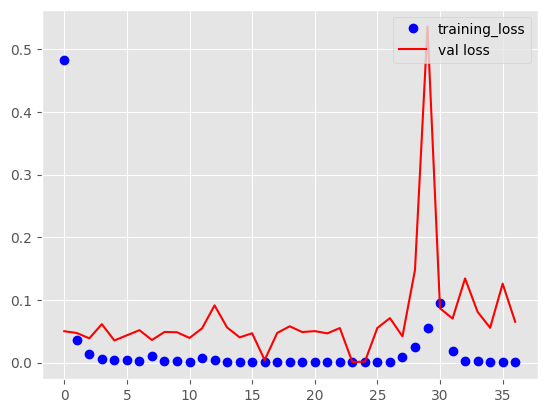

Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 10, 500), (187, 1)
6/6 [==============================] - 0s 3ms/step
pred :  array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc490135120>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.8609625668449198, 'mean': 0.8621978609625708, 'med': 0.8609625668449198, 'q1': 0.8128342245989305, 'q3': 0.9038770053475934, 'whislo': 0.786096256684492, 'whishi': 0.946524064171123}, 'f1 all': {'main': 0.8324255628177197, 'mean': 0.8311425600175538, 'med': 0.8314727714727714, 'q1': 0.7688343033352818, 'q3': 0.8876595363153733, 'whislo': 0.7430047465449873, 'whishi': 0.9192307692307692}, 'recall all': {'main': 0.8156028368794326, 'mean': 0.815291619804376, 'med': 0.8154761904761904, 'q1': 0.7647058823529411, 'q3': 0.8666981132075472, 'whislo': 0.7435897435897436, 'whishi': 0.8924731182795699}, 'precision all': {'main': 0.928374655647383, 'mean': 0.9290994298621963, 'med': 0.9291686990453627, 'q1': 0.9047619047619048, 'q3': 0.9520095238095237, 'whislo': 0.8888888888888888, 'whishi': 0.9682539682539683}, 'naive roc auc': {'main': 0.8862275449101796, 'mean': 0.8865266286912074, 'med': 0.8877401015533004, 'q1': 0.8471868007053016, 'q3

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc490134d60>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	1:00:47
	Energy:	0.096627919163 kWh
	CO2eq:	45.898261602590 g
	This is equivalent to:
	0.426960573047 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1677172_2023-10-11T100409Z_carbontracker_output.log
Sta

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc4901ac2e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape             

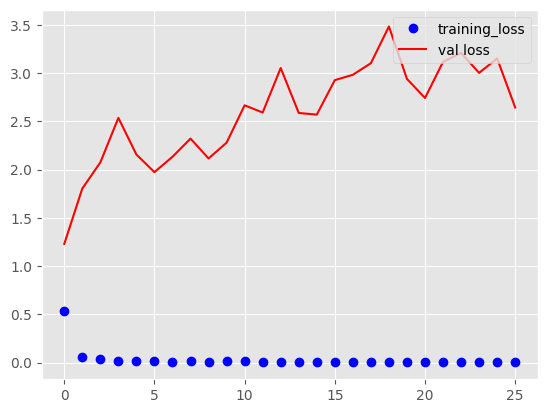

Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 10, 500), (187, 1)
6/6 [==============================] - 0s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc488386b60>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.9090909090909091, 'mean': 0.9093796791443748, 'med': 0.9090909090909091, 'q1': 0.8663101604278075, 'q3': 0.9518716577540107, 'whislo': 0.8342245989304813, 'whishi': 0.9732620320855615}, 'f1 all': {'main': 0.88994287692574, 'mean': 0.8895578225959583, 'med': 0.8910923412932039, 'q1': 0.8340338234362435, 'q3': 0.9404142326075411, 'whislo': 0.7969428666889409, 'whishi': 0.9682975621333876}, 'recall all': {'main': 0.9322188449848023, 'mean': 0.9322436679583813, 'med': 0.9326151918257181, 'q1': 0.8964284949591348, 'q3': 0.9642421193829644, 'whislo': 0.8634781397939293, 'whishi': 0.9758064516129032}, 'precision all': {'main': 0.8669677419354839, 'mean': 0.8674206689546534, 'med': 0.869015616999488, 'q1': 0.8080890645731977, 'q3': 0.9215762867647059, 'whislo': 0.7634803921568627, 'whishi': 0.9616412723870622}, 'naive roc auc': {'main': 0.9322188449848025, 'mean': 0.9322436679583813, 'med': 0.9326151918257182, 'q1': 0.8964284949591348, 'q

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc4e40bcdf0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc488313b20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_____________________

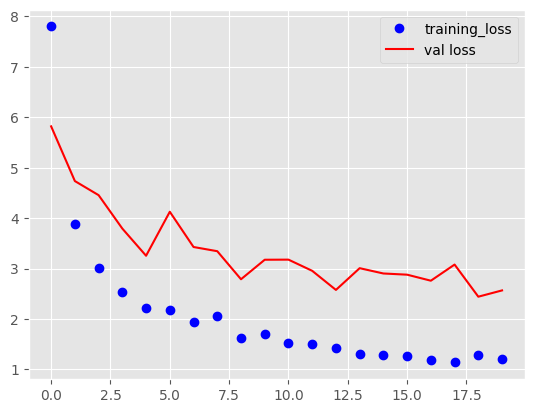

5/5 [==============================] - 0s 3ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 15., 15., 15., 15., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28., 28., 28.,
       28.], dtype=float32)
test pred :  array([ 0.        ,  0.        ,  0.        ,  0.        ,  5.4513803 ,
        0.        ,  0.        ,  1.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc491290c10>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'P': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 8.025759, 'mean': 8.027171, 'med': 8.044901, 'q1': 6.756371557712555, 'q3': 9.225074672698975, 'whislo': 6.0576925, 'whishi': 9.8786125}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracke

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc491290bb0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc4904e4f40>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.

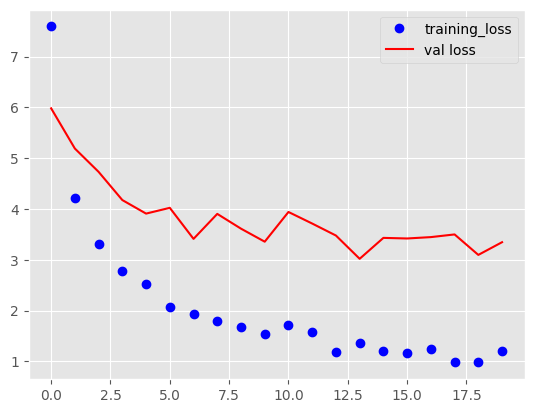

4/4 [==============================] - 0s 3ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 15.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28.,
       28., 28., 28., 28., 28., 28., 28.], dtype=float32)
test pred :  array([ 0.5818333,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  1.4120684,  0.       ,
        0.       ,  0.       ,  4.098478 , 10.030085 ,  4.220987 ,
        8.143194 ,  0

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc491019fc0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'T': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 12.386446, 'mean': 12.404694, 'med': 12.420496, 'q1': 10.009772968292236, 'q3': 14.818568539619445, 'whislo': 9.254995, 'whishi': 15.972194}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontr

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc491019f90>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc4b6f1e590>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.excepti

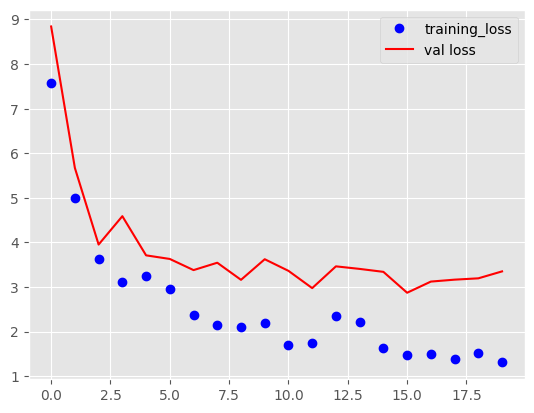

4/4 [==============================] - 0s 3ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([ 0.        ,  0.        ,  5.682518  ,  0.06605797,  0.        ,
        0.        ,  2.2956798 ,  0.        ,  6.8274674 ,  4.531954  ,
       10.098177  ,  6.8030057 ,  5.0487733 ,  0.        ,  3.8682666 ,
        9.64723   , 12.483872  ,  7.185149

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc490de40a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TH': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 9.138759, 'mean': 9.072379, 'med': 9.068651, 'q1': 6.97256371974945, 'q3': 11.21534595489502, 'whislo': 5.896302, 'whishi': 12.407015}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc490de43a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc490eb9720>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 input_1 (InputLayer)        [(None, 10, 500)]         0         
CarbonTracker: INFO -

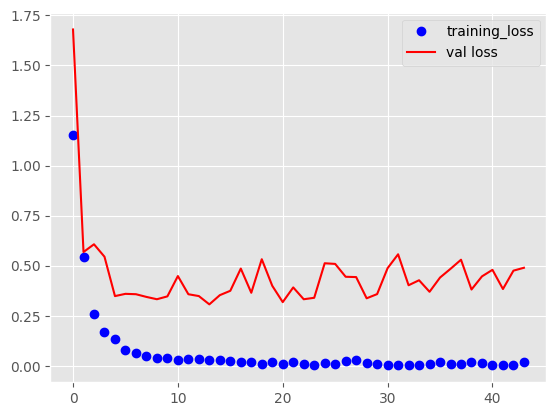

6/6 [==============================] - 0s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
   

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc490973670>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'PATTES': [{'acc': {'main': 0.9095744680851063, 'mean': 0.9089468085106355, 'med': 0.9095744680851063, 'q1': 0.8670212765957447, 'q3': 0.9468085106382979, 'whislo': 0.8404255319148937, 'whishi': 0.9680851063829787}, 'f1 all': {'main': 0.8706666506198943, 'mean': 0.8662544118587292, 'med': 0.8701939950276081, 'q1': 0.7901446450623567, 'q3': 0.935296045333708, 'whislo': 0.6977827727827728, 'whishi': 0.9723015873015873}, 'recall all': {'main': 0.8391156462585034, 'mean': 0.8377595568263682, 'med': 0.8405717454911268, 'q1': 0.7510049435787899, 'q3': 0.9183283015021924, 'whislo': 0.6421620046620047, 'whishi': 0.9620726495726495}, 'precision all': {'main': 0.9109726649280401, 'mean': 0.9105727420054731, 'med': 0.9132659545231416, 'q1': 0.8529424721351911, 'q3': 0.9576556516570385, 'whislo': 0.8241316833037058, 'whishi': 0.9839221014492754}, 'naive roc auc': {'main': 0.9353049907578558, 'mean': 0.9346376935696935, 'med': 0.9349798551673472, 'q1': 0.903940120903867

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc490972680>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc490ad92d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
 

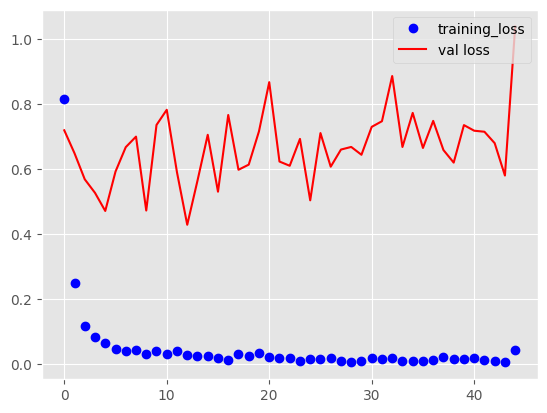

7/7 [==============================] - 0s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc488174100>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TETE': [{'acc': {'main': 0.8364485981308412, 'mean': 0.8379672897196254, 'med': 0.8364485981308412, 'q1': 0.7897196261682243, 'q3': 0.8878504672897196, 'whislo': 0.7663551401869159, 'whishi': 0.9158878504672897}, 'f1 all': {'main': 0.847331190294577, 'mean': 0.8476683830585282, 'med': 0.8475417163850336, 'q1': 0.8038606925071221, 'q3': 0.8904582355714966, 'whislo': 0.7761976047904191, 'whishi': 0.9078983918128655}, 'recall all': {'main': 0.8438552555168409, 'mean': 0.8451211368101261, 'med': 0.8443292690028832, 'q1': 0.8027757580061476, 'q3': 0.8865868343271799, 'whislo': 0.7774390243902439, 'whishi': 0.9031250000000001}, 'precision all': {'main': 0.8565526989763773, 'mean': 0.8579717162584837, 'med': 0.8576954610115415, 'q1': 0.8114632814632815, 'q3': 0.900228093695227, 'whislo': 0.7845042637138857, 'whishi': 0.9291666666666667}, 'naive roc auc': {'main': 0.8869774084653337, 'mean': 0.8877863886981143, 'med': 0.8887790914986512, 'q1': 0.8489724750004047, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc488176d10>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc48812c370>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontr

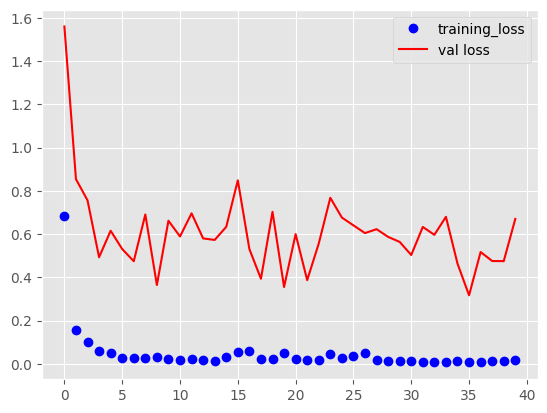

9/9 [==============================] - 0s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc46c75c190>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'THORAX': [{'acc': {'main': 0.8387096774193549, 'mean': 0.8380071684587814, 'med': 0.8387096774193549, 'q1': 0.7921146953405018, 'q3': 0.8781362007168458, 'whislo': 0.7670250896057348, 'whishi': 0.9175627240143369}, 'f1 all': {'main': 0.8364318663036902, 'mean': 0.8348616776644663, 'med': 0.8352511435938829, 'q1': 0.794083484161473, 'q3': 0.8745881320651125, 'whislo': 0.7706395156547168, 'whishi': 0.8953160084235238}, 'recall all': {'main': 0.8348989898989899, 'mean': 0.8342569649072252, 'med': 0.8351485370351469, 'q1': 0.7936305623805623, 'q3': 0.8737721375520972, 'whislo': 0.7724865554644063, 'whishi': 0.8995098039215687}, 'precision all': {'main': 0.8404586326004716, 'mean': 0.8397399902961253, 'med': 0.8402038698028873, 'q1': 0.79662958347311, 'q3': 0.8802201930158652, 'whislo': 0.7717672413793103, 'whishi': 0.9003599577980513}, 'naive roc auc': {'main': 0.8714177978883861, 'mean': 0.8713243637697893, 'med': 0.8724205318604685, 'q1': 0.8293753643292685,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc46c75d6f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [7]:
model_choice = 'esn_1d'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_espece, bootstrap_collect_espece = run_model_rec('MABSC_coh_espece', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_espece
TEST_BOOTSTRAP = bootstrap_collect_espece
df_res_mabsc_espece = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 species classification : abscessus, bolletti, massiliensse",position = 0)
del tableau_perf_espece, bootstrap_collect_espece, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_resistance, bootstrap_collect_resistance = run_model_rec('MABSC_coh_resistance', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_resistance
TEST_BOOTSTRAP = bootstrap_collect_resistance
df_res_mabsc_resistance = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 resistance classification : R, RIND, S",position = 0)
del tableau_perf_resistance, bootstrap_collect_resistance, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model_rec('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Pauline", position = 0)

TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n  = tableau_perf_noemie
TEST_BOOTSTRAP_n = bootstrap_collect_noemie
df_res_anophele_noemie = show_table_results_regression(TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n,TEST_BOOTSTRAP_n,
                                                       "Anophele Noémie", position = 0)

del tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie, TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model_rec('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on REC",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [8]:
#11/10/23
display(df_res_mabsc_espece)
display(df_res_mabsc_resistance)
display(df_res_anophele_pauline)
display(df_res_anophele_noemie)
display(df_res_anophele_ident)

,all
Metrics,
Test accuracy,0.86
,"[0.81,0.9]"
Test balanced accuracy,0.81
,"[0.76,0.87]"
Mean F1 score,0.83
,"[0.77,0.89]"
F1 score by categories,[0.88 0.62 1. ]
Mean precision,0.92
,"[0.9,0.95]"


,all
Metrics,
Test accuracy,0.90
,"[0.87,0.95]"
Test balanced accuracy,0.93
,"[0.9,0.96]"
Mean F1 score,0.88
,"[0.83,0.94]"
F1 score by categories,[0.94 0.84]
Mean precision,0.86
,"[0.81,0.92]"


,P,T,TH
Metrics,,,
Test MAE,2.99,3.35,2.85
,"[2.65,3.33]","[2.87,3.78]","[2.44,3.31]"
Roc AUC score,0.89,0.88,0.90
,"[0.86,0.92]","[0.86,0.91]","[0.87,0.93]"
R2 score,0.77,0.75,0.81


,P,T,TH
Metrics,,,
Test MAE,8.02,12.38,9.13
,"[6.76,9.23]","[10.01,14.82]","[6.97,11.22]"
Roc AUC score,0.50,0.50,0.50
,"[0.5,0.5]","[0.5,0.5]","[0.5,0.5]"
R2 score,-0.01,-1.90,-0.61


,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.90,0.83,0.83
,"[0.87,0.95]","[0.79,0.89]","[0.79,0.88]"
Test balanced accuracy,0.83,0.84,0.83
,"[0.75,0.92]","[0.8,0.89]","[0.79,0.87]"
Mean F1 score,0.87,0.84,0.83
,"[0.79,0.94]","[0.8,0.89]","[0.79,0.87]"
F1 score by categories,[0.96 0.88 0.89 0.76],[0.92 0.81 1. 0.66],[0.93 0.81 1. 0.6 ]
Mean precision,0.91,0.85,0.84
,"[0.85,0.96]","[0.81,0.9]","[0.8,0.88]"


## RNN-BiGRU

DATA :  MABSC_coh_espece


2023-10-11 00:32:33.560909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2
Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd408612ad0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train label :  [0, 1, 7, 12, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 4, 5, 14, 16, 3, 6, 8, 9, 13, 15, 18] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Val label :  [11, 22, 23, 29, 2, 10] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 2, 2]
Train data dimensions: (680, 5000, 1), (680, 1)
Validation data dimensions: (134, 5000, 1), (134, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (ty

2023-10-11 00:32:44.033710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-11 00:32:44.082919: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd387e312a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-11 00:32:44.082956: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-11 00:32:44.089232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-11 00:32:44.186496: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 [==============================] - 15s 101ms/step - loss: 0.6537 - categorical_accuracy: 0.7634 - f1_m: 0.7609 - val_loss: 0.1667 - val_categorical_accuracy: 0.9141 - val_f1_m: 0.9141
Epoch 2/50
42/42 [==============================] - 4s 87ms/step - loss: 0.1412 - categorical_accuracy: 0.9390 - f1_m: 0.9387 - val_loss: 0.0359 - val_categorical_accuracy: 0.9766 - val_f1_m: 0.9803
Epoch 3/50
42/42 [==============================] - 4s 87ms/step - loss: 0.0138 - categorical_accuracy: 0.9926 - f1_m: 0.9926 - val_loss: 0.0768 - val_categorical_accuracy: 0.9844 - val_f1_m: 0.9844
Epoch 4/50
42/42 [==============================] - 4s 103ms/step - loss: 0.0199 - categorical_accuracy: 0.9926 - f1_m: 0.9926 - val_loss: 0.1162 - val_categorical_accuracy: 0.9766 - val_f1_m: 0.9766
Epoch 5/50
42/42 [==============================] - 4s 85ms/step - loss: 0.0024 - categorical_accuracy: 1.0000 - f1_m: 1.0000 - val_loss: 0.0653 - val_categorical_accuracy: 0.9922 - val_f1_m: 0.9922
Epoch 6/50
42

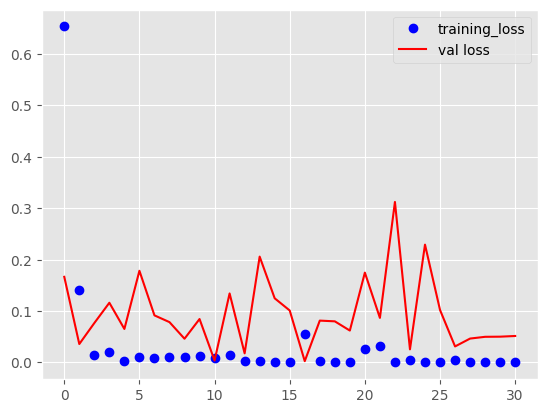

Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 10, 500), (187, 1)
6/6 [==============================] - 1s 7ms/step
pred :  array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b0e9d780>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.9572192513368984, 'mean': 0.9564545454545561, 'med': 0.9572192513368984, 'q1': 0.9251336898395722, 'q3': 0.983957219251337, 'whislo': 0.893048128342246, 'whishi': 0.9946524064171123}, 'f1 all': {'main': 0.955524234594002, 'mean': 0.9545054942434705, 'med': 0.9556589147286821, 'q1': 0.9215766979651603, 'q3': 0.9825799419327546, 'whislo': 0.8953427524856097, 'whishi': 0.9948589921405455}, 'recall all': {'main': 0.9432624113475176, 'mean': 0.9426852111699054, 'med': 0.9433962264150942, 'q1': 0.904739010989011, 'q3': 0.9767441860465116, 'whislo': 0.882716049382716, 'whishi': 0.9935897435897436}, 'precision all': {'main': 0.9741100323624595, 'mean': 0.9736202907347785, 'med': 0.9738562091503268, 'q1': 0.95578231292517, 'q3': 0.9900049019607842, 'whislo': 0.933993399339934, 'whishi': 0.9968253968253968}, 'naive roc auc': {'main': 0.9649930907415938, 'mean': 0.9645122196508994, 'med': 0.9653578608526354, 'q1': 0.938380237386235, 'q3': 0.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b0e9d7e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	2:17:18
	Energy:	0.248003470036 kWh
	CO2eq:	117.801648267266 g
	This is equivalent to:
	1.095829286207 km travelled by car
CarbonTracker: Finished monitoring.
#######################################################################################
Carbon Tracker : 
Output file name: ./logs/App_methodo/1600143_2023-10-11T001905Z_carbontracker_output.log
St

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b846c8e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape             

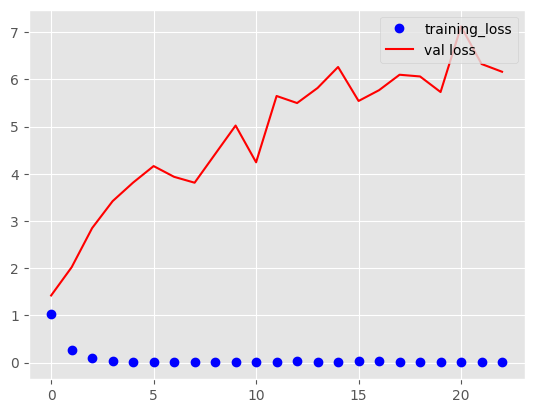

Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 10, 500), (187, 1)
6/6 [==============================] - 1s 7ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b04d3700>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.7433155080213903, 'mean': 0.7448556149732621, 'med': 0.7433155080213903, 'q1': 0.6844919786096256, 'q3': 0.8021390374331551, 'whislo': 0.6524064171122995, 'whishi': 0.8288770053475936}, 'f1 all': {'main': 0.7275376396308888, 'mean': 0.7269951699711285, 'med': 0.7275376396308888, 'q1': 0.6564504357437696, 'q3': 0.7905460118239969, 'whislo': 0.6253443526170799, 'whishi': 0.8153890824622532}, 'recall all': {'main': 0.8285714285714285, 'mean': 0.8301357992447064, 'med': 0.8300326797385621, 'q1': 0.791044776119403, 'q3': 0.8680646929824561, 'whislo': 0.7733812949640289, 'whishi': 0.8904109589041096}, 'precision all': {'main': 0.7473684210526316, 'mean': 0.7468304540091322, 'med': 0.7473684210526316, 'q1': 0.6935273857526882, 'q3': 0.7976253799392098, 'whislo': 0.6684782608695652, 'whishi': 0.8282828282828283}, 'naive roc auc': {'main': 0.8285714285714286, 'mean': 0.8301357992447064, 'med': 0.8300326797385621, 'q1': 0.7910447761194029, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b025afe0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b0e9e380>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: INFO -

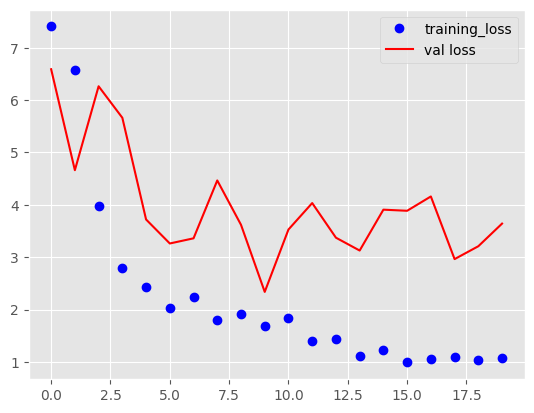

5/5 [==============================] - 0s 7ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 15., 15., 15., 15., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28., 28., 28.,
       28.], dtype=float32)
test pred :  array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b8dec700>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'P': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 7.919041, 'mean': 7.8881536, 'med': 7.9170227, 'q1': 6.578638184070587, 'q3': 9.201448440551758, 'whislo': 5.613367, 'whishi': 9.9291315}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontrack

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b8dec6d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b2755a20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.excepti

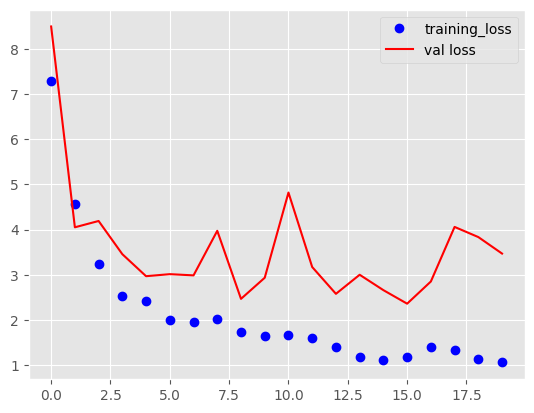

4/4 [==============================] - 0s 7ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 15.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28.,
       28., 28., 28., 28., 28., 28., 28.], dtype=float32)
test pred :  array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  1.0324538,
        0.       ,  0.       ,  2.0865293,  4.707482 ,  2.1082108,
        4.335292 ,  1

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b2069f30>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'T': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 8.763837, 'mean': 8.800301, 'med': 8.783068, 'q1': 6.922555911540985, 'q3': 10.84554283618927, 'whislo': 5.4031763, 'whishi': 12.194}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.e

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b2069f00>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b22d6710>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (mos

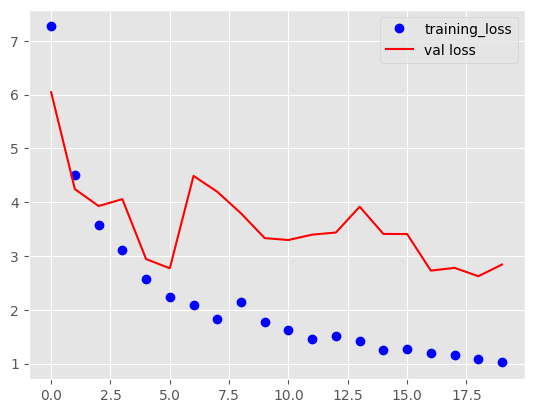

4/4 [==============================] - 0s 7ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.7235109 ,  0.48965952,
        1.8166423 ,  1.5193304 ,  3.118964  ,  3.4751785 ,  3.5871344 ,
        5.0387826 ,  2.9111297 ,  4.320831

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b3fd8a30>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TH': [[{'naive roc auc': {'main': 0.5, 'mean': 0.5, 'med': 0.5, 'q1': 0.5, 'q3': 0.5, 'whislo': 0.5, 'whishi': 0.5}}, {'mae': {'main': 8.4303, 'mean': 8.440356, 'med': 8.438322, 'q1': 6.778048992156982, 'q3': 10.118193626403809, 'whislo': 5.197513, 'whishi': 11.365809}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3b3fd88e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3887216c0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-pack

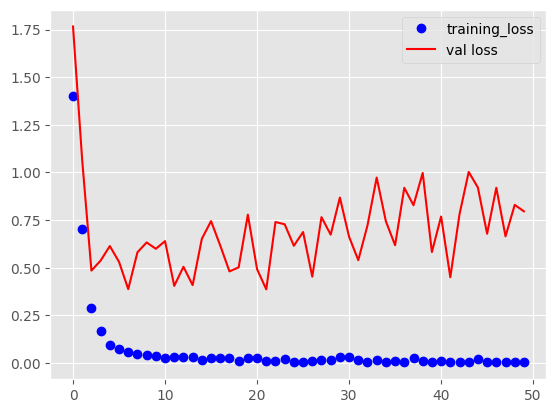

6/6 [==============================] - 0s 7ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3881a7580>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'PATTES': [{'acc': {'main': 0.9414893617021277, 'mean': 0.9413936170212752, 'med': 0.9414893617021277, 'q1': 0.9095744680851063, 'q3': 0.973404255319149, 'whislo': 0.8829787234042553, 'whishi': 0.9893617021276596}, 'f1 all': {'main': 0.9290051841632175, 'mean': 0.9281816545853034, 'med': 0.9293761207957127, 'q1': 0.8776355422651518, 'q3': 0.9706548135310731, 'whislo': 0.8397468897468896, 'whishi': 0.9890491571169417}, 'recall all': {'main': 0.9125, 'mean': 0.9128738981171791, 'med': 0.9137358183950074, 'q1': 0.8548935802313884, 'q3': 0.9631395687645687, 'whislo': 0.8233137829912024, 'whishi': 0.985}, 'precision all': {'main': 0.9510526369919368, 'mean': 0.9514212287530155, 'med': 0.9534631583002814, 'q1': 0.9122765226671476, 'q3': 0.9816079009433962, 'whislo': 0.8772035256410257, 'whishi': 0.9936440677966102}, 'naive roc auc': {'main': 0.9581792975970426, 'mean': 0.9581497649485745, 'med': 0.9588091834685355, 'q1': 0.9359046055405368, 'q3': 0.97986989606250

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3881a7610>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd3953deec0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 500)]         0         
                     

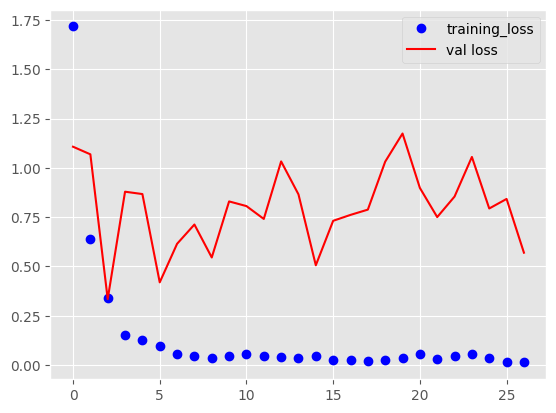

7/7 [==============================] - 1s 7ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd389603190>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TETE': [{'acc': {'main': 0.7850467289719626, 'mean': 0.7847383177570091, 'med': 0.7850467289719626, 'q1': 0.7289719626168224, 'q3': 0.8411214953271028, 'whislo': 0.7009345794392523, 'whishi': 0.8644859813084113}, 'f1 all': {'main': 0.8045504385964912, 'mean': 0.8029009290854766, 'med': 0.8031544601225744, 'q1': 0.7607462029538705, 'q3': 0.8461473031570512, 'whislo': 0.7334453781512605, 'whishi': 0.8626126126126126}, 'recall all': {'main': 0.8103948896631824, 'mean': 0.8096337709975637, 'med': 0.8091813461255727, 'q1': 0.7656858228549405, 'q3': 0.8547674752975928, 'whislo': 0.7396899224806202, 'whishi': 0.8684088806660499}, 'precision all': {'main': 0.805026455026455, 'mean': 0.8043036098532942, 'med': 0.8039852234753551, 'q1': 0.7640596494032396, 'q3': 0.8462260337260338, 'whislo': 0.7400359604435122, 'whishi': 0.8615551115551116}, 'naive roc auc': {'main': 0.8853544533887302, 'mean': 0.8854540379760646, 'med': 0.8864865008033167, 'q1': 0.8488287710983278,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd389603100>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd37c2e3520>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - T

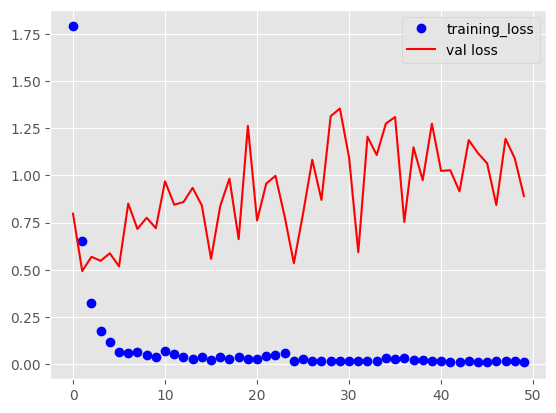

9/9 [==============================] - 1s 7ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd38a78aad0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'THORAX': [{'acc': {'main': 0.8566308243727598, 'mean': 0.8563870967741948, 'med': 0.8566308243727598, 'q1': 0.8136200716845878, 'q3': 0.8960573476702509, 'whislo': 0.7706093189964157, 'whishi': 0.921146953405018}, 'f1 all': {'main': 0.8497910334346503, 'mean': 0.8485260869770019, 'med': 0.8480467462576775, 'q1': 0.8093867322957448, 'q3': 0.8902605080575495, 'whislo': 0.7804132736919832, 'whishi': 0.9075123345165539}, 'recall all': {'main': 0.847020202020202, 'mean': 0.846497563347627, 'med': 0.8457536349107295, 'q1': 0.8080913221499221, 'q3': 0.8868295879556908, 'whislo': 0.7815350877192982, 'whishi': 0.8990712074303405}, 'precision all': {'main': 0.854020599428364, 'mean': 0.8537961294773363, 'med': 0.8538003720436418, 'q1': 0.8127283957115724, 'q3': 0.895990948323413, 'whislo': 0.7811815252416756, 'whishi': 0.9222369188915494}, 'naive roc auc': {'main': 0.9128016591251885, 'mean': 0.9127538965173757, 'med': 0.9131604234974163, 'q1': 0.8848214906741457, '

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fd38a78aa40>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [10]:
model_choice = 'rec_1d'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_espece, bootstrap_collect_espece = run_model_rec('MABSC_coh_espece', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_espece
TEST_BOOTSTRAP = bootstrap_collect_espece
df_res_mabsc_espece = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 species classification : abscessus, bolletti, massiliensse",position = 0)
del tableau_perf_espece, bootstrap_collect_espece, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_resistance, bootstrap_collect_resistance = run_model_rec('MABSC_coh_resistance', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_resistance
TEST_BOOTSTRAP = bootstrap_collect_resistance
df_res_mabsc_resistance = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 resistance classification : R, RIND, S",position = 0)
del tableau_perf_resistance, bootstrap_collect_resistance, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model_rec('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Pauline", position = 0)

TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n  = tableau_perf_noemie
TEST_BOOTSTRAP_n = bootstrap_collect_noemie
df_res_anophele_noemie = show_table_results_regression(TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n,TEST_BOOTSTRAP_n,
                                                       "Anophele Noémie", position = 0)

del tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie, TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model_rec('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on REC",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [11]:
#10/10/23
display(df_res_mabsc_espece)
display(df_res_mabsc_resistance)
display(df_res_anophele_pauline)
display(df_res_anophele_noemie)
display(df_res_anophele_ident)

,all
Metrics,
Test accuracy,0.95
,"[0.93,0.98]"
Test balanced accuracy,0.94
,"[0.9,0.98]"
Mean F1 score,0.95
,"[0.92,0.98]"
F1 score by categories,[0.96 0.91 1. ]
Mean precision,0.97
,"[0.96,0.99]"


,all
Metrics,
Test accuracy,0.74
,"[0.68,0.8]"
Test balanced accuracy,0.82
,"[0.79,0.87]"
Mean F1 score,0.72
,"[0.66,0.79]"
F1 score by categories,[0.79 0.66]
Mean precision,0.74
,"[0.69,0.8]"


,P,T,TH
Metrics,,,
Test MAE,2.77,3.36,2.80
,"[2.39,3.14]","[2.81,3.9]","[2.27,3.34]"
Roc AUC score,0.92,0.92,0.94
,"[0.9,0.95]","[0.9,0.95]","[0.92,0.96]"
R2 score,0.79,0.70,0.78


,P,T,TH
Metrics,,,
Test MAE,7.91,8.76,8.43
,"[6.58,9.2]","[6.92,10.85]","[6.78,10.12]"
Roc AUC score,0.50,0.50,0.50
,"[0.5,0.5]","[0.5,0.5]","[0.5,0.5]"
R2 score,0.00,-0.64,-0.32


,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.94,0.78,0.85
,"[0.91,0.97]","[0.73,0.84]","[0.81,0.9]"
Test balanced accuracy,0.91,0.81,0.84
,"[0.85,0.96]","[0.77,0.85]","[0.81,0.89]"
Mean F1 score,0.92,0.80,0.84
,"[0.88,0.97]","[0.76,0.85]","[0.81,0.89]"
F1 score by categories,[0.98 0.91 1. 0.83],[1. 0.7 1. 0.52],[0.98 0.8 1. 0.62]
Mean precision,0.95,0.80,0.85
,"[0.91,0.98]","[0.76,0.85]","[0.81,0.9]"


# Convolution Models

In [9]:
def run_model(data_name, model_name):
    
    if data_name == 'MABSC_coh_espece':
        print("DATA : ", data_name )
        data_name = 'MABSC_coh'
        data_train, data_test = data_uploading(data_name)
        feature_of_stratification = 'souche'
        colonne = 'Intensite align msiwarp'
        target = 'espece'
        number_class = 3
        EPOCH = 50
        BATCH = 12
        types = 'classification'
        
        start = timeit.default_timer()

        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)
        
        tracker = CarbonTracker(epochs=50 , components = "gpu", log_dir = "./logs/App_methodo")
        tracker.epoch_start()

        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types, set_class_weight = True)

        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)

        del data_train, data_test

        essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)

        tableau_perf_espece = performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(tableau_perf_espece)

        bootstrap_collect_espece = bootstrap_performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(bootstrap_collect_espece)
        
        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")

        print("ICI : ", logs)
        
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")
        
        essaie.clean_model_session()
        
        return tableau_perf_espece, bootstrap_collect_espece
    
    elif data_name == 'MABSC_coh_resistance':
        print("DATA : ", data_name )
        data_name = 'MABSC_coh'
        data_train, data_test = data_uploading(data_name)
        
        data_train['resistance'] = data_train.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        data_test['resistance'] = data_test.apply (lambda row: ajout_colonne_mabsc_resistance_binaire(row), axis=1)
        
        feature_of_stratification = 'souche'
        colonne = 'Intensite align msiwarp'
        target = 'resistance'
        number_class = 2
        EPOCH = 50
        BATCH = 32
        types = 'classification'
        
        start = timeit.default_timer()

        essaie = Methodology_models(model_name, len_sp, number_class)

        tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(data_train, len_sp, feature_of_stratification,
                                                          target, colonne, encode=True, n_splits_k_fold = 5, random_state_val = 1234)

        tracker = CarbonTracker(epochs=50 ,components = "gpu",log_dir = "./logs/App_methodo")
        tracker.epoch_start()
        
        essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types, set_class_weight = True)

        tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(data_test, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)

        del data_train, data_test

        essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)

        tableau_perf_resistance = performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(tableau_perf_resistance)
        
        bootstrap_collect_resistance = bootstrap_performances(y_tst_data,essaie_compile_y_test, types, 'all')
        print(bootstrap_collect_resistance)
        
        tracker.epoch_end()
        tracker.stop()
        
        logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
        first_log = logs[0]
        
        print("#######################################################################################")
        print("Carbon Tracker : ")
        print(f"Output file name: {first_log['output_filename']}")
        print(f"Standard file name: {first_log['standard_filename']}")
        print(f"Stopped early: {first_log['early_stop']}")
        print(f"Measured consumption: {first_log['actual']}")
        print(f"Predicted consumption: {first_log['pred']}")
        print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")
        
        # Clear any logs from previous runs
        remove_files_in_folder("./logs/App_methodo")
        
        print("#######################################################################################")
        
        stop = timeit.default_timer()

        print("***************************************************************************************")

        print('Time of {}: '.format(data_name), stop - start)

        print("***************************************************************************************")
        
        essaie.clean_model_session()
        
        return tableau_perf_resistance, bootstrap_collect_resistance
    
    
    elif data_name == 'Anophele_age':
        print("DATA : ", data_name )
        data_train, test_pauline, test_noemie = data_uploading(data_name)
        
        data_train['regression'] = data_train.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        test_pauline['regression'] = test_pauline.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        test_noemie['regression'] = test_noemie.apply (lambda row: ajout_colonne_anatomie_regression(row), axis=1)
        
        #data_train['Partie anatomique'] = data_train.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        #test_pauline['Partie anatomique'] = test_pauline.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        #test_noemie['Partie anatomique'] = test_noemie.apply (lambda row: ajout_colonne_anatomie(row), axis=1)
        
        feature_of_stratification = 'sous_fichier'
        colonne = 'Intensite align msiwarp'
        target = 'regression'
        number_class = 1
        EPOCH = 50
        BATCH = 32
        types = 'regression'
        
        tableau_perf_pauline_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_pauline_all = collections.defaultdict(list)
        tableau_perf_noemie_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_noemie_all = collections.defaultdict(list)

        for part_anatom in ['P', 'T', 'TH']: 
            print("Partie anatomique : ", part_anatom)
            train = data_train[data_train['Partie anatomique']==part_anatom]
            train = train.reset_index(drop=True)

            tst_pauline = test_pauline[test_pauline['Partie anatomique']==part_anatom]
            tst_pauline = tst_pauline.reset_index(drop=True)
            tst_noemie = test_noemie[test_noemie['Partie anatomique']==part_anatom]
            tst_noemie = tst_noemie.reset_index(drop=True)
            
            start = timeit.default_timer()

            essaie = Methodology_models(model_name, len_sp, number_class)

            tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False, n_splits_k_fold = 5, random_state_val = 1234)

            tst_data_pauline, y_tst_data_pauline = essaie.data_preparation_zero_shot_test(tst_pauline, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False)

            tst_data_noemie, y_tst_data_noemie = essaie.data_preparation_zero_shot_test(tst_noemie, len_sp, feature_of_stratification,
                                                          target, colonne, encode = False)

            del train, tst_pauline, tst_noemie
            
            
            tracker = CarbonTracker(epochs=50 ,components = "gpu",log_dir = "./logs/App_methodo")
            tracker.epoch_start()


            essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types)

            essaie_compile_y_test_pauline = essaie.model_predict(tst_data_pauline, y_tst_data_pauline, types)
            tableau_perf_pauline = performances(y_tst_data_pauline, essaie_compile_y_test_pauline, types, part_anatom)
            print(tableau_perf_pauline)
            for el, el_update in zip(tableau_perf_pauline, tableau_perf_pauline_all):
                el_update.update(el)
            
            bootstrap_collect_pauline = bootstrap_performances(y_tst_data_pauline, essaie_compile_y_test_pauline, types, part_anatom)
            print(bootstrap_collect_pauline)
            bootstrap_collect_pauline_all.update(bootstrap_collect_pauline)

            essaie_compile_y_test_noemie = essaie.model_predict(tst_data_noemie, y_tst_data_noemie, types)
            tableau_perf_noemie = performances(y_tst_data_noemie, essaie_compile_y_test_noemie, types, part_anatom)
            print(tableau_perf_noemie)
            for el, el_update in zip(tableau_perf_noemie, tableau_perf_noemie_all):
                el_update.update(el)
            
            bootstrap_collect_noemie = bootstrap_performances(y_tst_data_noemie, essaie_compile_y_test_noemie, types, part_anatom)
            print(bootstrap_collect_noemie)
            bootstrap_collect_noemie_all.update(bootstrap_collect_noemie)
            
            tracker.epoch_end()
            tracker.stop()

            logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
            first_log = logs[0]

            print("#######################################################################################")
            print("Carbon Tracker : ")
            print(f"Output file name: {first_log['output_filename']}")
            print(f"Standard file name: {first_log['standard_filename']}")
            print(f"Stopped early: {first_log['early_stop']}")
            print(f"Measured consumption: {first_log['actual']}")
            print(f"Predicted consumption: {first_log['pred']}")
            print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")

            # Clear any logs from previous runs
            remove_files_in_folder("./logs/App_methodo")

            print("#######################################################################################")

            stop = timeit.default_timer()

            print("***************************************************************************************")
    
            print('Time of {}: '.format(data_name), stop - start)
    
            print("***************************************************************************************")
            
            essaie.clean_model_session()

            del tr_data, y_tr_data, va_data, y_va_data, tst_data_pauline, y_tst_data_pauline, tst_data_noemie, y_tst_data_noemie
            
        
        return tableau_perf_pauline_all, bootstrap_collect_pauline_all, tableau_perf_noemie_all, bootstrap_collect_noemie_all
    
    
    elif data_name == 'Anophele_identif':
        print("DATA : ", data_name )
        data_train, data_test = data_uploading(data_name)
        
        data_train = data_train[~data_train.espece.isin(['Hybrides An. coluzzii-gambiae'])]
        data_test = data_test[~data_test.espece.isin(['Hybrides An. coluzzii-gambiae'])]

        feature_of_stratification = 'sous_fichier'
        colonne = 'Intensite align msiwarp'
        target = 'espece'
        number_class = 4
        EPOCH = 50
        BATCH = 64
        types = 'classification'
        
        
        tableau_perf_all = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list),collections.defaultdict(list),collections.defaultdict(list), collections.defaultdict(list)
        bootstrap_collect_all = collections.defaultdict(list)

        for part_anatom in ['PATTES', 'TETE', 'THORAX']:
            print("Partie anatomique : ", part_anatom)
            train = data_train[data_train['anatom']==part_anatom] 
            train = train.reset_index(drop=True)

            tst = data_test[data_test['anatom']==part_anatom] 
            tst = tst.reset_index(drop=True)
            
            start = timeit.default_timer()

            essaie = Methodology_models(model_name, len_sp, number_class)

            tr_data, y_tr_data, va_data, y_va_data = essaie.data_preparation_zero_shot_train(train, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True, n_splits_k_fold = 5, random_state_val = 1234)

            tst_data, y_tst_data = essaie.data_preparation_zero_shot_test(tst, len_sp, feature_of_stratification,
                                                          target, colonne, encode = True)


            del train, tst
            
            
            tracker = CarbonTracker(epochs=50 ,components = "gpu", log_dir = "./logs/App_methodo")
            tracker.epoch_start()


            essaie_compile = essaie.model_fit_compile(tr_data, y_tr_data, va_data, y_va_data, BATCH, EPOCH, types, set_class_weight = True)

            essaie_compile_y_test = essaie.model_predict(tst_data, y_tst_data, types)
            
            tableau_perf = performances(y_tst_data, essaie_compile_y_test, types, part_anatom)
            print(tableau_perf)
            for el, el_update in zip(tableau_perf, tableau_perf_all):
                el_update.update(el)
        
            bootstrap_collect = bootstrap_performances(y_tst_data, essaie_compile_y_test, types, part_anatom)
            print(bootstrap_collect)
            bootstrap_collect_all.update(bootstrap_collect)
            
            tracker.epoch_end()
            tracker.stop()

            logs = parser.parse_all_logs(log_dir="./logs/App_methodo")
            first_log = logs[0]

            print("#######################################################################################")
            print("Carbon Tracker : ")
            print(f"Output file name: {first_log['output_filename']}")
            print(f"Standard file name: {first_log['standard_filename']}")
            print(f"Stopped early: {first_log['early_stop']}")
            print(f"Measured consumption: {first_log['actual']}")
            print(f"Predicted consumption: {first_log['pred']}")
            print(f"Measured GPU devices: {first_log['components']['gpu']['devices']}")

            # Clear any logs from previous runs
            remove_files_in_folder("./logs/App_methodo")

            print("#######################################################################################")

            stop = timeit.default_timer()

            print("***************************************************************************************")
    
            print('Time of {}: '.format(data_name), stop - start)
    
            print("***************************************************************************************")
            
            essaie.clean_model_session()
            
            del tr_data, y_tr_data, va_data, y_va_data, tst_data, y_tst_data
            
            
        return tableau_perf_all, bootstrap_collect_all
    
    
    
    else :
        raise ValueError("Data name unknown")
        
        
    
 

## TCN 1D

DATA :  MABSC_coh_espece


2023-10-07 21:32:28.064818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Train label :  [0, 1, 7, 12, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 4, 5, 14, 16, 3, 6, 8, 9, 13, 15, 18] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Val label :  [11, 22, 23, 29, 2, 10] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 2, 2]


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f95a4a6b100>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Train data dimensions: (680, 17999), (680, 1)
Validation data dimensions: (134, 17999), (134, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
_________________________________________________________________
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17999, 1)]        0         
                                                                 
 spatial_dropout1d (Spatial  (None, 17999, 1)          0         
 Dropout1D)                                                      
          

2023-10-07 21:32:33.321795: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-07 21:32:34.062288: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f95581ab790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-07 21:32:34.062325: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-07 21:32:34.069332: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-07 21:32:34.165283: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - 6s 17ms/step - loss: 1.1085 - categorical_accuracy: 0.5059 - f1_m: 0.4932 - val_loss: 0.4726 - val_categorical_accuracy: 0.8955 - val_f1_m: 0.9031
Epoch 2/50
57/57 [==============================] - 0s 8ms/step - loss: 0.6432 - categorical_accuracy: 0.6471 - f1_m: 0.6722 - val_loss: 0.4122 - val_categorical_accuracy: 0.9030 - val_f1_m: 0.9097
Epoch 3/50
57/57 [==============================] - 1s 9ms/step - loss: 0.5572 - categorical_accuracy: 0.6456 - f1_m: 0.7140 - val_loss: 0.1120 - val_categorical_accuracy: 0.9552 - val_f1_m: 0.9583
Epoch 4/50
57/57 [==============================] - 1s 10ms/step - loss: 0.5312 - categorical_accuracy: 0.7926 - f1_m: 0.7270 - val_loss: 0.7371 - val_categorical_accuracy: 0.9030 - val_f1_m: 0.9097
Epoch 5/50
57/57 [==============================] - 1s 11ms/step - loss: 0.4083 - categorical_accuracy: 0.7309 - f1_m: 0.7901 - val_loss: 0.5704 - val_categorical_accuracy: 0.9030 - val_f1_m: 0.9097
Epoch 6/50
57/57 [

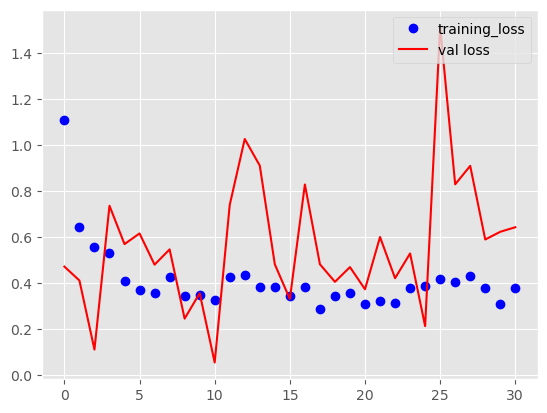

Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 17999), (187, 1)
6/6 [==============================] - 0s 14ms/step
pred :  array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f959de3c070>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.8181818181818182, 'mean': 0.819385026737972, 'med': 0.8181818181818182, 'q1': 0.7647058823529411, 'q3': 0.8716577540106952, 'whislo': 0.7112299465240641, 'whishi': 0.9037433155080213}, 'f1 all': {'main': 0.7554461001062943, 'mean': 0.7543000458597414, 'med': 0.7558156207301823, 'q1': 0.6837767610801805, 'q3': 0.8175375009696325, 'whislo': 0.6290929809567638, 'whishi': 0.8624185039279378}, 'recall all': {'main': 0.7696155281821575, 'mean': 0.769616050821569, 'med': 0.7691703570754576, 'q1': 0.721255977058802, 'q3': 0.8156002599550987, 'whislo': 0.6888888888888888, 'whishi': 0.8572115714972858}, 'precision all': {'main': 0.8633404536669719, 'mean': 0.8643067922496568, 'med': 0.8647040476338297, 'q1': 0.8203921195079877, 'q3': 0.9068519384931326, 'whislo': 0.7956291695422131, 'whishi': 0.9274551320830812}, 'naive roc auc': {'main': 0.8724550898203592, 'mean': 0.8724900401251245, 'med': 0.8732343614874604, 'q1': 0.83417996707381, 'q3'

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f959de3c310>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:51:04
	Energy:	0.104635062725 kWh
	CO2eq:	49.701654794261 g
	This is equivalent to:
	0.462340974830 km travelled by car
CarbonTracker: Finished monitoring.
ICI :  [{'output_filename': './logs/App_methodo/909171_2023-10-07T213229Z_carbontracker_output.log', 'standard_filename': './logs/App_methodo/909171_2023-10-07T213229Z_carbontracker.log', 'component

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f959ba3ad10>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape             

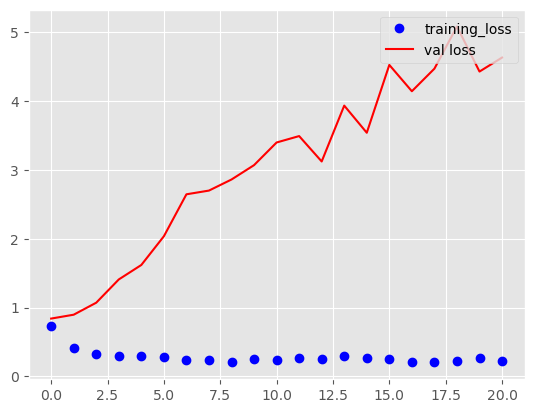

Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 17999), (187, 1)
6/6 [==============================] - 0s 6ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f957b62b3a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.7647058823529411, 'mean': 0.7654866310160399, 'med': 0.7647058823529411, 'q1': 0.7058823529411765, 'q3': 0.8235294117647058, 'whislo': 0.6684491978609626, 'whishi': 0.8502673796791443}, 'f1 all': {'main': 0.7473593711618768, 'mean': 0.7472234578807869, 'med': 0.7474004963402758, 'q1': 0.6815933157986805, 'q3': 0.8115958670252709, 'whislo': 0.6476895146096666, 'whishi': 0.8366812227074236}, 'recall all': {'main': 0.8428571428571429, 'mean': 0.8432691638573668, 'med': 0.84375, 'q1': 0.8049645390070922, 'q3': 0.8814864291772689, 'whislo': 0.7727272727272727, 'whishi': 0.9047619047619048}, 'precision all': {'main': 0.7582417582417582, 'mean': 0.759014869837106, 'med': 0.758929836995039, 'q1': 0.7088475738396625, 'q3': 0.810530148185999, 'whislo': 0.6686746987951807, 'whishi': 0.8333333333333333}, 'naive roc auc': {'main': 0.8428571428571429, 'mean': 0.8432691638573668, 'med': 0.84375, 'q1': 0.8049645390070922, 'q3': 0.8814864291772689

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f957b62b760>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f959bae4130>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Test data dimensions: (144, 17999), (144, 1)
Non encode target
Test label :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12] size :  13
Y test clone/non clone :  [ 0  0  3  6  6 10 10 15 15 20 20 28 28]
Test data dimensions: (52, 17999), (52, 1)
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (

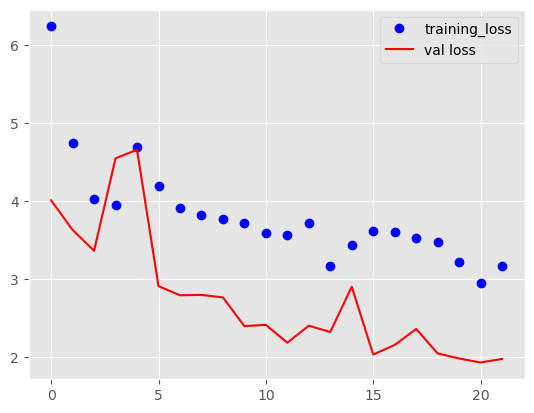

5/5 [==============================] - 0s 15ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 15., 15., 15., 15., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28., 28., 28.,
       28.], dtype=float32)
test pred :  array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.      

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f957bfb8ee0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'P': [[{'naive roc auc': {'main': 0.8862847222222222, 'mean': 0.8861387150050792, 'med': 0.8861859252823632, 'q1': 0.8238377879506227, 'q3': 0.9443716651011396, 'whislo': 0.7839506172839507, 'whishi': 0.9625570776255707}}, {'mae': {'main': 3.2437932, 'mean': 3.2626555, 'med': 3.2548409, 'q1': 2.2929401636123656, 'q3': 4.232475352287293, 'whislo': 1.8751043, 'whishi': 5.0858164}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in c

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f957bfb86d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f959b9e1ba0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

_____________________

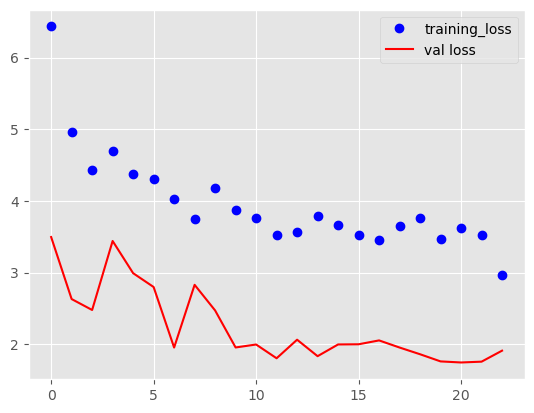

4/4 [==============================] - 0s 23ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 15.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28.,
       28., 28., 28., 28., 28., 28., 28.], dtype=float32)
test pred :  array([ 0.        ,  0.7601954 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  4.378329  ,  5.952728  ,
        5.019708  ,  5.4005313 ,  0.99497956,  1.1393682 ,  1.1113123 ,
     

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f957899fbe0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'T': [[{'naive roc auc': {'main': 0.9730902777777778, 'mean': 0.9728778130870951, 'med': 0.9742105104991111, 'q1': 0.9444904439147562, 'q3': 0.9918514524988395, 'whislo': 0.9228624535315985, 'whishi': 0.9982222222222222}}, {'mae': {'main': 2.3957138, 'mean': 2.3860042, 'med': 2.3866458, 'q1': 1.9093949317932128, 'q3': 2.923140674829483, 'whislo': 1.6579958, 'whishi': 3.282408}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in ca

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f957899f760>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f959b9d9ea0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
   

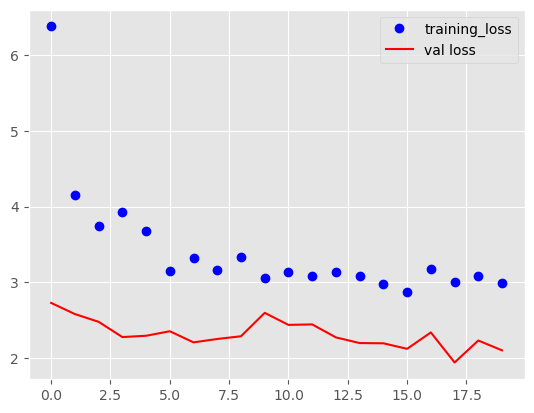

4/4 [==============================] - 0s 20ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  3.704627 ,  2.7884312,
        3.47596  ,  3.365519 ,  1.9645498,  3.2955842,  3.384748 ,
        3.3604198,  5.0555964,  4.3139477,  5.8124266,  

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9578652620>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TH': [[{'naive roc auc': {'main': 0.9427083333333334, 'mean': 0.9441021797372644, 'med': 0.9468040800338937, 'q1': 0.8948258455325594, 'q3': 0.9809812570931006, 'whislo': 0.8451957295373665, 'whishi': 1.0}}, {'mae': {'main': 2.2459435, 'mean': 2.2439861, 'med': 2.2334218, 'q1': 1.6486859709024428, 'q3': 2.8717753469944, 'whislo': 1.3198562, 'whishi': 3.1915534}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9578652650>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f95787afc40>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Validation data dimensions: (222, 17999), (222, 1)
Test label :  [14 15 16 17 18 19 26 27 28 29 30 31 32 33 34 35 36 37 38 39  0  1  2  3
  4  5  6  7  8 11 12 13 20 21  9 10 22 23 24 25] size :  40
Y test clone/non clone :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 3 3
 3 3 3]
Test data dimensions: (188, 17999), (188, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationEr

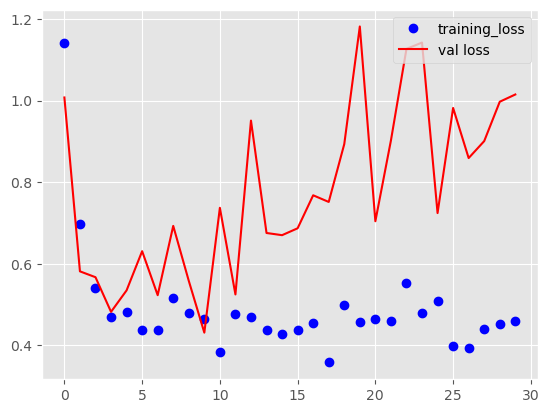

6/6 [==============================] - 0s 6ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9426e5ec50>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'PATTES': [{'acc': {'main': 0.9148936170212766, 'mean': 0.9159840425531905, 'med': 0.9202127659574468, 'q1': 0.8670212765957447, 'q3': 0.9521276595744681, 'whislo': 0.8297872340425532, 'whishi': 0.9840425531914894}, 'f1 all': {'main': 0.8809523809523809, 'mean': 0.8806335238689547, 'med': 0.8805863392663377, 'q1': 0.8260842212459392, 'q3': 0.9276991195559653, 'whislo': 0.7880906971816063, 'whishi': 0.9744257636751125}, 'recall all': {'main': 0.8999999999999999, 'mean': 0.9016136432000219, 'med': 0.9031556372549019, 'q1': 0.8412552521008404, 'q3': 0.9493435974969827, 'whislo': 0.8012820512820513, 'whishi': 0.9858490566037736}, 'precision all': {'main': 0.8736263736263736, 'mean': 0.8746226574863888, 'med': 0.8758140008140007, 'q1': 0.8227924465240642, 'q3': 0.9202920418810748, 'whislo': 0.7872023809523809, 'whishi': 0.9725274725274726}, 'naive roc auc': {'main': 0.9630314232902033, 'mean': 0.9637000249260986, 'med': 0.9647855024173155, 'q1': 0.94059741956761

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9426e5ce20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f957ab11330>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

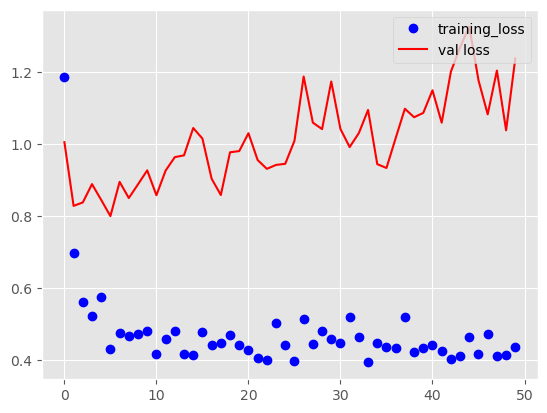

7/7 [==============================] - 0s 14ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f943082b280>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TETE': [{'acc': {'main': 0.8037383177570093, 'mean': 0.8046448598130834, 'med': 0.8037383177570093, 'q1': 0.7523364485981309, 'q3': 0.8551401869158879, 'whislo': 0.7289719626168224, 'whishi': 0.897196261682243}, 'f1 all': {'main': 0.8168776371308016, 'mean': 0.8159898131674657, 'med': 0.8156809750927398, 'q1': 0.7751767727639001, 'q3': 0.8587263912343094, 'whislo': 0.7402954311233253, 'whishi': 0.8819554848966613}, 'recall all': {'main': 0.8196864111498257, 'mean': 0.8199468755317447, 'med': 0.8199378881987578, 'q1': 0.7788273446170921, 'q3': 0.8628951149425287, 'whislo': 0.7413101604278075, 'whishi': 0.8843178621659634}, 'precision all': {'main': 0.8157894736842105, 'mean': 0.8160206528803671, 'med': 0.8156539825422804, 'q1': 0.776186755952381, 'q3': 0.8577416370750386, 'whislo': 0.7407539118065434, 'whishi': 0.8800391389432485}, 'naive roc auc': {'main': 0.8921059465074007, 'mean': 0.8931599948599944, 'med': 0.8942769529110752, 'q1': 0.8586442103156838, 

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9430828700>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f94307ded70>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following compone

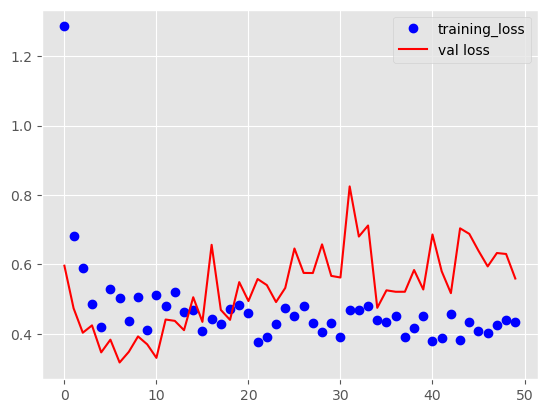

9/9 [==============================] - 0s 12ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9426a3e770>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'THORAX': [{'acc': {'main': 0.8566308243727598, 'mean': 0.8567168458781378, 'med': 0.8566308243727598, 'q1': 0.8171146953405019, 'q3': 0.8960573476702509, 'whislo': 0.7992831541218638, 'whishi': 0.9175627240143369}, 'f1 all': {'main': 0.850373599003736, 'mean': 0.8491173953253703, 'med': 0.8489878323141857, 'q1': 0.8110548843497002, 'q3': 0.8878137215552143, 'whislo': 0.7947473699103885, 'whishi': 0.9026269271664009}, 'recall all': {'main': 0.8497474747474748, 'mean': 0.8493388446074842, 'med': 0.8495209212750989, 'q1': 0.809532732010556, 'q3': 0.8895728509432544, 'whislo': 0.7933746893252714, 'whishi': 0.9019542772861358}, 'precision all': {'main': 0.851081026469994, 'mean': 0.8505891952976803, 'med': 0.8497497625501631, 'q1': 0.8133807086337437, 'q3': 0.8904035147144941, 'whislo': 0.7960377358490566, 'whishi': 0.9125792811839324}, 'naive roc auc': {'main': 0.9134615384615384, 'mean': 0.9137019256588944, 'med': 0.9136030526608354, 'q1': 0.8847701900112334,

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9426a3d750>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [10]:
model_choice = 'tcn_1d'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_espece, bootstrap_collect_espece = run_model('MABSC_coh_espece', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_espece
TEST_BOOTSTRAP = bootstrap_collect_espece
df_res_mabsc_espece = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 species classification : abscessus, bolletti, massiliensse",position = 0)
del tableau_perf_espece, bootstrap_collect_espece, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_resistance, bootstrap_collect_resistance = run_model('MABSC_coh_resistance', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_resistance
TEST_BOOTSTRAP = bootstrap_collect_resistance
df_res_mabsc_resistance = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 resistance classification : R (et RIND), S",position = 0)
del tableau_perf_resistance, bootstrap_collect_resistance, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Pauline", position = 0)

TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n  = tableau_perf_noemie
TEST_BOOTSTRAP_n = bootstrap_collect_noemie
df_res_anophele_noemie = show_table_results_regression(TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n,TEST_BOOTSTRAP_n,
                                                       "Anophele Noémie", position = 0)

del tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie, TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on TCN",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


## Results for article

In [11]:
#07/10/23
display(df_res_mabsc_espece) #we keep this one
display(df_res_mabsc_resistance) #wrong batch size so we do not keep this one
display(df_res_anophele_pauline) 
display(df_res_anophele_noemie)
display(df_res_anophele_noemie)
display(df_res_anophele_ident)

,all
Metrics,
Test accuracy,0.81
,"[0.76,0.87]"
Test balanced accuracy,0.76
,"[0.72,0.82]"
Mean F1 score,0.75
,"[0.68,0.82]"
F1 score by categories,[0.88 0.51 0.87]
Mean precision,0.86
,"[0.82,0.91]"


,all
Metrics,
Test accuracy,0.76
,"[0.71,0.82]"
Test balanced accuracy,0.84
,"[0.8,0.88]"
Mean F1 score,0.74
,"[0.68,0.81]"
F1 score by categories,[0.81 0.68]
Mean precision,0.75
,"[0.71,0.81]"


,P,T,TH
Metrics,,,
Test MAE,2.49,2.08,1.94
,"[2.19,2.84]","[1.74,2.46]","[1.65,2.23]"
Roc AUC score,0.92,0.94,0.95
,"[0.9,0.94]","[0.92,0.96]","[0.93,0.97]"
R2 score,0.83,0.88,0.91


,P,T,TH
Metrics,,,
Test MAE,3.24,2.39,2.24
,"[2.29,4.23]","[1.91,2.92]","[1.65,2.87]"
Roc AUC score,0.88,0.97,0.94
,"[0.82,0.94]","[0.94,0.99]","[0.89,0.98]"
R2 score,0.73,0.87,0.88


,P,T,TH
Metrics,,,
Test MAE,3.24,2.39,2.24
,"[2.29,4.23]","[1.91,2.92]","[1.65,2.87]"
Roc AUC score,0.88,0.97,0.94
,"[0.82,0.94]","[0.94,0.99]","[0.89,0.98]"
R2 score,0.73,0.87,0.88


,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.91,0.80,0.85
,"[0.87,0.95]","[0.75,0.86]","[0.82,0.9]"
Test balanced accuracy,0.89,0.81,0.84
,"[0.84,0.95]","[0.78,0.86]","[0.81,0.89]"
Mean F1 score,0.88,0.81,0.85
,"[0.83,0.93]","[0.78,0.86]","[0.81,0.89]"
F1 score by categories,[1. 0.86 1. 0.67],[1. 0.73 1. 0.53],[1. 0.8 1. 0.61]
Mean precision,0.87,0.81,0.85
,"[0.82,0.92]","[0.78,0.86]","[0.81,0.89]"


In [15]:
#07/10/23
display(df_res_mabsc_espece) #wrong batch size so we do not keep this one
display(df_res_mabsc_resistance) #we keep this one 
display(df_res_anophele_pauline) #we keep this one Senegal 1
display(df_res_anophele_noemie) 
display(df_res_anophele_noemie)
display(df_res_anophele_ident) #we keep this one

,all
Metrics,
Test accuracy,0.75
,"[0.7,0.82]"
Test balanced accuracy,0.69
,"[0.66,0.72]"
Mean F1 score,0.63
,"[0.57,0.69]"
F1 score by categories,[0.84 0.19 0.87]
Mean precision,0.83
,"[0.79,0.88]"


,all
Metrics,
Test accuracy,0.98
,"[0.97,1.0]"
Test balanced accuracy,0.96
,"[0.93,1.0]"
Mean F1 score,0.97
,"[0.95,1.0]"
F1 score by categories,[0.99 0.97]
Mean precision,0.98
,"[0.98,1.0]"


,P,T,TH
Metrics,,,
Test MAE,2.77,2.64,2.08
,"[2.43,3.11]","[2.29,3.07]","[1.78,2.41]"
Roc AUC score,0.90,0.93,0.94
,"[0.88,0.93]","[0.9,0.95]","[0.92,0.96]"
R2 score,0.80,0.83,0.90


,P,T,TH
Metrics,,,
Test MAE,3.53,3.52,2.52
,"[2.51,4.7]","[2.63,4.57]","[1.93,3.13]"
Roc AUC score,0.88,0.87,0.93
,"[0.82,0.94]","[0.81,0.94]","[0.9,0.97]"
R2 score,0.65,0.69,0.86


,P,T,TH
Metrics,,,
Test MAE,3.53,3.52,2.52
,"[2.51,4.7]","[2.63,4.57]","[1.93,3.13]"
Roc AUC score,0.88,0.87,0.93
,"[0.82,0.94]","[0.81,0.94]","[0.9,0.97]"
R2 score,0.65,0.69,0.86


,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.94,0.78,0.85
,"[0.91,0.97]","[0.73,0.84]","[0.81,0.9]"
Test balanced accuracy,0.92,0.81,0.84
,"[0.87,0.97]","[0.76,0.86]","[0.8,0.88]"
Mean F1 score,0.91,0.80,0.84
,"[0.87,0.96]","[0.76,0.85]","[0.8,0.89]"
F1 score by categories,[1. 0.92 1. 0.76],[0.98 0.72 1. 0.53],[0.99 0.8 1. 0.6 ]
Mean precision,0.91,0.80,0.85
,"[0.86,0.96]","[0.76,0.85]","[0.81,0.89]"


## CNN 1D

DATA :  MABSC_coh_espece


2023-10-07 21:04:33.513734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11463 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Train label :  [0, 1, 7, 12, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 4, 5, 14, 16, 3, 6, 8, 9, 13, 15, 18] size :  27
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]
Val label :  [11, 22, 23, 29, 2, 10] size :  6
Y val clone/non clone :  [0, 0, 0, 0, 2, 2]
Train data dimensions: (680, 17999), (680, 1)


Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc37e611a20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Validation data dimensions: (134, 17999), (134, 1)
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17999, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 17994, 3)          21        
                                                                 
 max_pooling1d (MaxPooling1  (None, 179, 3)            0

2023-10-07 21:04:37.078307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-07 21:04:38.285708: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc3381dfcc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-07 21:04:38.285748: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-10-07 21:04:38.294171: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-07 21:04:38.395212: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - 5s 11ms/step - loss: 0.4430 - categorical_accuracy: 0.8471 - f1_m: 0.8474 - val_loss: 0.1911 - val_categorical_accuracy: 0.9403 - val_f1_m: 0.9444
Epoch 2/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0639 - categorical_accuracy: 0.9882 - f1_m: 0.9860 - val_loss: 0.2217 - val_categorical_accuracy: 0.9403 - val_f1_m: 0.9444
Epoch 3/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0275 - categorical_accuracy: 0.9956 - f1_m: 0.9949 - val_loss: 0.3883 - val_categorical_accuracy: 0.9179 - val_f1_m: 0.9236
Epoch 4/50
57/57 [==============================] - 0s 6ms/step - loss: 0.0129 - categorical_accuracy: 0.9985 - f1_m: 0.9985 - val_loss: 0.2564 - val_categorical_accuracy: 0.9403 - val_f1_m: 0.9444
Epoch 5/50
57/57 [==============================] - 0s 5ms/step - loss: 0.0062 - categorical_accuracy: 1.0000 - f1_m: 1.0000 - val_loss: 0.0593 - val_categorical_accuracy: 0.9776 - val_f1_m: 0.9792
Epoch 6/50
57/57 [==

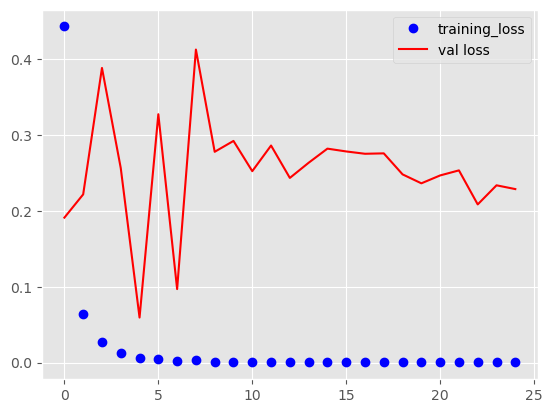

Test label :  [0 3 4 5 1 7 2 6] size :  8
Y test clone/non clone :  [0 0 0 0 1 1 2 2]
Test data dimensions: (187, 17999), (187, 1)
6/6 [==============================] - 0s 6ms/step
pred :  array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc42cc408e0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.8235294117647058, 'mean': 0.8222513368984, 'med': 0.8235294117647058, 'q1': 0.7647058823529411, 'q3': 0.8770053475935828, 'whislo': 0.7272727272727273, 'whishi': 0.9144385026737968}, 'f1 all': {'main': 0.7643568667254584, 'mean': 0.7614394872031176, 'med': 0.7617803087198047, 'q1': 0.6926266123018818, 'q3': 0.8276485344488634, 'whislo': 0.6360242266926238, 'whishi': 0.8884727099319374}, 'recall all': {'main': 0.7760773091120236, 'mean': 0.7747781377290434, 'med': 0.7749436704363977, 'q1': 0.7186475763241614, 'q3': 0.8256192406521353, 'whislo': 0.6926423735563519, 'whishi': 0.880039331366765}, 'precision all': {'main': 0.8201248170867613, 'mean': 0.8168729442689876, 'med': 0.8179599501028072, 'q1': 0.7439765802127185, 'q3': 0.8803773427566421, 'whislo': 0.7081196581196582, 'whishi': 0.91820987654321}, 'naive roc auc': {'main': 0.8946568401658223, 'mean': 0.8943197303805887, 'med': 0.8948630005279989, 'q1': 0.8610518868668029, 'q3':

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc42cc41510>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:42:39
	Energy:	0.067838751005 kWh
	CO2eq:	32.223406727575 g
	This is equivalent to:
	0.299752620722 km travelled by car
CarbonTracker: Finished monitoring.
ICI :  [{'output_filename': './logs/App_methodo/903788_2023-10-07T210434Z_carbontracker_output.log', 'standard_filename': './logs/App_methodo/903788_2023-10-07T210434Z_carbontracker.log', 'component

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc3759ad5a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape             

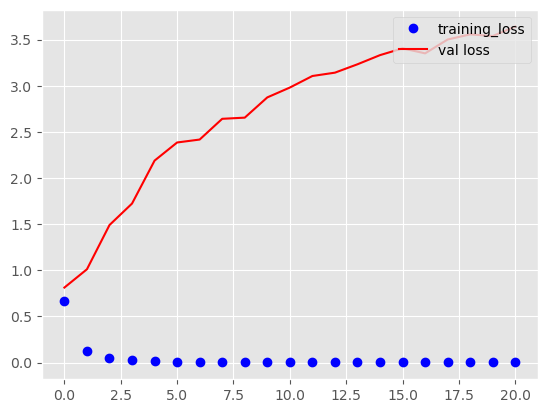

Test label :  [0 1 3 5 6 7 2 4] size :  8
Y test clone/non clone :  [0 0 0 0 0 0 1 1]
Test data dimensions: (187, 17999), (187, 1)
6/6 [==============================] - 0s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc3702ecee0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'all': [{'acc': {'main': 0.9893048128342246, 'mean': 0.9893101604278145, 'med': 0.9893048128342246, 'q1': 0.9732620320855615, 'q3': 1.0, 'whislo': 0.9625668449197861, 'whishi': 1.0}, 'f1 all': {'main': 0.985986211031175, 'mean': 0.9858451473404324, 'med': 0.9865196078431373, 'q1': 0.9619333709572737, 'q3': 1.0, 'whislo': 0.9483934555489848, 'whishi': 1.0}, 'recall all': {'main': 0.9928571428571429, 'mean': 0.9928697208719027, 'med': 0.993006993006993, 'q1': 0.981748470373551, 'q3': 1.0, 'whislo': 0.9742647058823529, 'whishi': 1.0}, 'precision all': {'main': 0.9795918367346939, 'mean': 0.9795513992960989, 'med': 0.9807692307692308, 'q1': 0.9464091614906832, 'q3': 1.0, 'whislo': 0.9270833333333333, 'whishi': 1.0}, 'naive roc auc': {'main': 0.9928571428571429, 'mean': 0.9928697208719027, 'med': 0.993006993006993, 'q1': 0.9817484703735508, 'q3': 1.0, 'whislo': 0.9742647058823529, 'whishi': 1.0}, 'balanced accuracy': {'main': 0.9928571428571429, 'mean': 0.992869

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc3702ed810>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: Live carbon intensity could not be fetched at detected location: Unknown. Defaulted to average carbon intensity for world in 2019 of 475.00 gCO2/kWh. at detected location: UNDETECTED.
CarbonTracker: Live carbon intensit

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc375723e20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-pack

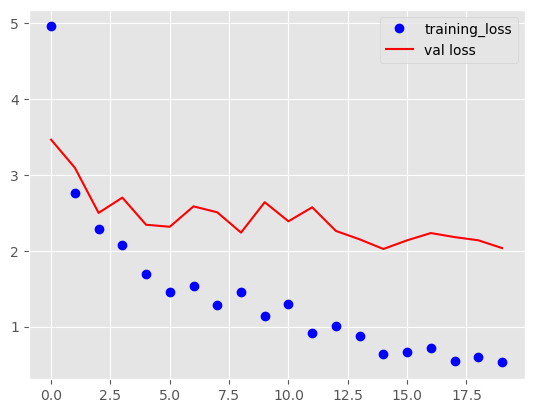

5/5 [==============================] - 0s 7ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 15., 15., 15., 15., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28., 28., 28.,
       28.], dtype=float32)
test pred :  array([ 0.       ,  0.       ,  0.       ,  0.       ,  2.5976458,
        0.       ,  0.       ,  0.       

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc263ff9a80>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'P': [[{'naive roc auc': {'main': 0.9157986111111112, 'mean': 0.9161034441258514, 'med': 0.9174028475372018, 'q1': 0.8647391877442666, 'q3': 0.9593933752361792, 'whislo': 0.827490774907749, 'whishi': 0.9844464775846294}}, {'mae': {'main': 2.8209727, 'mean': 2.8257437, 'med': 2.8048844, 'q1': 2.057512581348419, 'q3': 3.7048010528087616, 'whislo': 1.5794665, 'whishi': 4.5667615}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in ca

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc263ff9c60>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc375849540>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.excepti

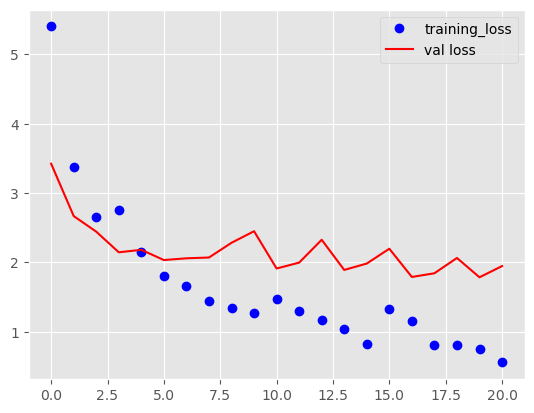

4/4 [==============================] - 0s 9ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,  8.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
        8., 10., 10., 10., 10., 15., 15., 15., 15., 15., 15., 15., 15.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 28.,
       28., 28., 28., 28., 28., 28., 28.], dtype=float32)
test pred :  array([ 0.        ,  0.19924222,  0.        ,  0.        ,  0.        ,
        0.        ,  0.68465006,  0.        ,  4.3619576 ,  6.7756944 ,
        5.358546  ,  5.4700675 ,  2.158831  ,  3.142325  ,  2.7902734 ,
      

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc2fb76beb0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'T': [[{'naive roc auc': {'main': 0.9348958333333334, 'mean': 0.9358009642187204, 'med': 0.9371403152605877, 'q1': 0.895624543832617, 'q3': 0.9663543777640717, 'whislo': 0.8633484162895928, 'whishi': 0.9821905609973286}}, {'mae': {'main': 2.6178641, 'mean': 2.6283367, 'med': 2.623331, 'q1': 2.106436312198639, 'q3': 3.1616215527057645, 'whislo': 1.7999918, 'whishi': 3.5585568}}]]})
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in car

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc2fb7a81f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc37581fdc0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following compone

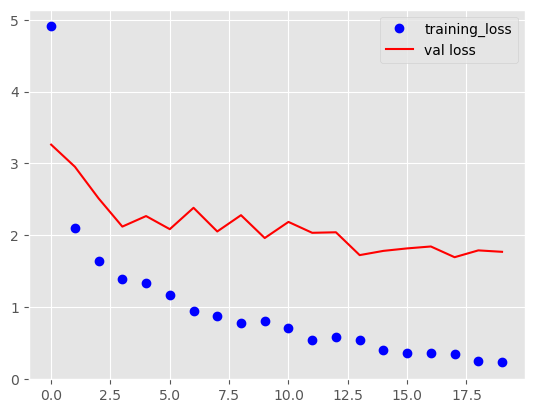

4/4 [==============================] - 0s 9ms/step
pred :  array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  8.,  8.,
        8.,  8.,  8.,  8.,  8.,  8., 10., 10., 10., 10., 10., 10., 10.,
       10., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 20., 20., 20., 20.,
       20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 24.,
       24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24., 24.,
       24., 24., 24., 24., 24., 24., 28., 28., 28., 28., 28., 28., 28.],
      dtype=float32)
test pred :  array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  7.5303164 ,  6.360903  ,
        7.326915  ,  7.0810494 ,  2.4262166 ,  2.2480872 ,  2.2304087 ,
        3.2188241 ,  5.337891  ,  4.617603

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc2fb6f4a00>: Failed to establish a new connection: [Errno -2] Name or service not known'))



CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise excep

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc2fb6f49d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc2fb68a560>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
Model: "model"
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/pytho

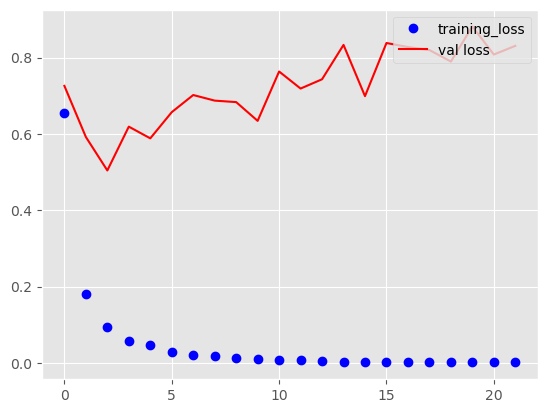

6/6 [==============================] - 0s 3ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc37e437400>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'PATTES': [{'acc': {'main': 0.8776595744680851, 'mean': 0.8772606382978712, 'med': 0.8776595744680851, 'q1': 0.8297872340425532, 'q3': 0.9202127659574468, 'whislo': 0.7925531914893617, 'whishi': 0.9414893617021277}, 'f1 all': {'main': 0.8411838766347842, 'mean': 0.8393984254852302, 'med': 0.8404905205402016, 'q1': 0.7823383230766653, 'q3': 0.8931142519553258, 'whislo': 0.7437867215041128, 'whishi': 0.9278199865014645}, 'recall all': {'main': 0.8541666666666667, 'mean': 0.8543202413964658, 'med': 0.8563100082800416, 'q1': 0.794605845845223, 'q3': 0.9086729760352641, 'whislo': 0.7471719457013574, 'whishi': 0.9376068376068376}, 'precision all': {'main': 0.839213463163043, 'mean': 0.83905868914045, 'med': 0.8403865954156005, 'q1': 0.7852084553092432, 'q3': 0.8897496844616632, 'whislo': 0.750429061784897, 'whishi': 0.9221467629569404}, 'naive roc auc': {'main': 0.9367837338262477, 'mean': 0.937072749329797, 'med': 0.9376410123520773, 'q1': 0.9113360858213496, 'q

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc3702ee4a0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc2fb6f5570>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

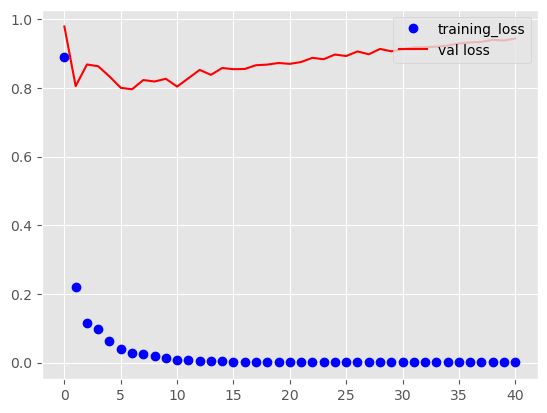

7/7 [==============================] - 0s 6ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc200263e80>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'TETE': [{'acc': {'main': 0.794392523364486, 'mean': 0.7949532710280366, 'med': 0.794392523364486, 'q1': 0.7336448598130841, 'q3': 0.8457943925233645, 'whislo': 0.705607476635514, 'whishi': 0.8691588785046729}, 'f1 all': {'main': 0.8054578840443819, 'mean': 0.8054380980980943, 'med': 0.8059552086737194, 'q1': 0.7579078247611559, 'q3': 0.8500490964476922, 'whislo': 0.7244818838822792, 'whishi': 0.8681493146842081}, 'recall all': {'main': 0.8077816492450638, 'mean': 0.8089176165742163, 'med': 0.8091010488664859, 'q1': 0.7610910310294291, 'q3': 0.8534472987597987, 'whislo': 0.7250430292598967, 'whishi': 0.8776437541308658}, 'precision all': {'main': 0.8042571300999051, 'mean': 0.8053530078112529, 'med': 0.8056215244782318, 'q1': 0.7587784326181065, 'q3': 0.8476741854636591, 'whislo': 0.7261392886392887, 'whishi': 0.867858170310702}, 'naive roc auc': {'main': 0.8765255777720072, 'mean': 0.8770479021612645, 'med': 0.8777050260929282, 'q1': 0.8350597276689704, 'q

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc200260220>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc20021ec20>: Failed to establish a new connection: [Errno -2] Name or service not known'))


Test data dimensions: (279, 17999), (279, 1)
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: The following components were found: GPU with device(s) NVIDIA GeForce GTX TITAN X.
CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

Model: "model"
CarbonTracker: The following components were found: GPU with device(s) NVID

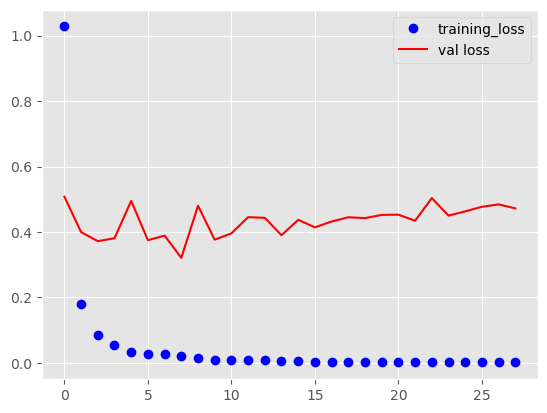

9/9 [==============================] - 0s 5ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc22ef784f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))


defaultdict(<class 'list'>, {'THORAX': [{'acc': {'main': 0.8817204301075269, 'mean': 0.8816738351254488, 'med': 0.8817204301075269, 'q1': 0.8422043010752688, 'q3': 0.9175627240143369, 'whislo': 0.8172043010752689, 'whishi': 0.946236559139785}, 'f1 all': {'main': 0.8727661344189936, 'mean': 0.8716766706752442, 'med': 0.8729833749167732, 'q1': 0.8273319224469182, 'q3': 0.9108468945919479, 'whislo': 0.8029338588154128, 'whishi': 0.9358288770053476}, 'recall all': {'main': 0.8745959595959596, 'mean': 0.8744034336677052, 'med': 0.8752331578265936, 'q1': 0.8316459992533599, 'q3': 0.9118263192186474, 'whislo': 0.809593023255814, 'whishi': 0.9308898305084746}, 'precision all': {'main': 0.8722914032869784, 'mean': 0.872216706959621, 'med': 0.8741509721727536, 'q1': 0.8249169743962894, 'q3': 0.9147142253763765, 'whislo': 0.7961487729528967, 'whishi': 0.9460084588950568}, 'naive roc auc': {'main': 0.9291289592760181, 'mean': 0.9292369912733399, 'med': 0.93034063347511, 'q1': 0.9031431811261431, '

Status code Unknown from http://ipinfo.io/json: ERROR - HTTPConnectionPool(host='ipinfo.io', port=80): Max retries exceeded with url: /json (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fc22ef78370>: Failed to establish a new connection: [Errno -2] Name or service not known'))


CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise exceptions.IPLocationError("Failed to retrieve location based on IP.")
carbontracker.exceptions.IPLocationError: Failed to retrieve location based on IP.

CarbonTracker: INFO - Traceback (most recent call last):
  File "/home/noshine/.conda/envs/env_gpu_noshine_new/lib/python3.10/site-packages/carbontracker/emissions/intensity/intensity.py", line 94, in carbon_intensity
    raise except

In [9]:
model_choice = 'cnn_1d'

TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_espece, bootstrap_collect_espece = run_model('MABSC_coh_espece', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_espece
TEST_BOOTSTRAP = bootstrap_collect_espece
df_res_mabsc_espece = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 species classification : abscessus, bolletti, massiliensse",position = 0)
del tableau_perf_espece, bootstrap_collect_espece, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf_resistance, bootstrap_collect_resistance = run_model('MABSC_coh_resistance', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf_resistance
TEST_BOOTSTRAP = bootstrap_collect_resistance
df_res_mabsc_resistance = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "MABSC 3 resistance classification : R, RIND, S",position = 0)
del tableau_perf_resistance, bootstrap_collect_resistance, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP



TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie = run_model('Anophele_age', model_choice)

TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p  = tableau_perf_pauline
TEST_BOOTSTRAP_p = bootstrap_collect_pauline
df_res_anophele_pauline = show_table_results_regression(TEST_MAE_p, TEST_ROC_AUC_p, TEST_R2_SCORE_p,TEST_BOOTSTRAP_p,
                                                        "Anophele Pauline", position = 0)

TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n  = tableau_perf_noemie
TEST_BOOTSTRAP_n = bootstrap_collect_noemie
df_res_anophele_noemie = show_table_results_regression(TEST_MAE_n, TEST_ROC_AUC_n, TEST_R2_SCORE_n,TEST_BOOTSTRAP_n,
                                                       "Anophele Noémie", position = 0)

del tableau_perf_pauline, bootstrap_collect_pauline, tableau_perf_noemie, bootstrap_collect_noemie, TEST_MAE, TEST_ROC_AUC, TEST_R2_SCORE, TEST_BOOTSTRAP



TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on CNN",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


## Results for article

In [10]:
#07/10/23
display(df_res_mabsc_espece)  #we keep this one 
display(df_res_mabsc_resistance) #we keep this one 
display(df_res_anophele_pauline) #we keep this one Senegal 1
display(df_res_anophele_noemie)
display(df_res_anophele_noemie)
display(df_res_anophele_ident)#Execution was interrupted during training, so we did not keep this one

,all
Metrics,
Test accuracy,0.82
,"[0.76,0.88]"
Test balanced accuracy,0.77
,"[0.72,0.83]"
Mean F1 score,0.76
,"[0.69,0.83]"
F1 score by categories,[0.92 0.55 0.83]
Mean precision,0.82
,"[0.74,0.88]"


,all
Metrics,
Test accuracy,0.98
,"[0.97,1.0]"
Test balanced accuracy,0.99
,"[0.98,1.0]"
Mean F1 score,0.98
,"[0.96,1.0]"
F1 score by categories,[0.99 0.98]
Mean precision,0.97
,"[0.95,1.0]"


,P,T,TH
Metrics,,,
Test MAE,2.27,2.04,1.92
,"[2.0,2.54]","[1.77,2.38]","[1.67,2.17]"
Roc AUC score,0.92,0.95,0.95
,"[0.91,0.95]","[0.93,0.97]","[0.94,0.97]"
R2 score,0.86,0.89,0.92


,P,T,TH
Metrics,,,
Test MAE,2.82,2.61,2.10
,"[2.06,3.7]","[2.11,3.16]","[1.6,2.65]"
Roc AUC score,0.91,0.93,0.94
,"[0.86,0.96]","[0.9,0.97]","[0.91,0.98]"
R2 score,0.80,0.86,0.90


,P,T,TH
Metrics,,,
Test MAE,2.82,2.61,2.10
,"[2.06,3.7]","[2.11,3.16]","[1.6,2.65]"
Roc AUC score,0.91,0.93,0.94
,"[0.86,0.96]","[0.9,0.97]","[0.91,0.98]"
R2 score,0.80,0.86,0.90


,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.87,0.79,0.88
,"[0.83,0.92]","[0.73,0.85]","[0.84,0.92]"
Test balanced accuracy,0.85,0.80,0.87
,"[0.79,0.91]","[0.76,0.85]","[0.83,0.91]"
Mean F1 score,0.84,0.80,0.87
,"[0.78,0.89]","[0.76,0.85]","[0.83,0.91]"
F1 score by categories,[0.98 0.79 1. 0.6 ],[0.99 0.73 1. 0.5 ],[0.99 0.83 0.98 0.69]
Mean precision,0.83,0.80,0.87
,"[0.79,0.89]","[0.76,0.85]","[0.82,0.91]"


2023-10-02 15:18:47.252709: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Train label :  [32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 45, 46, 47, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 107, 108, 109, 110, 111, 112, 114, 115, 116, 157, 158, 159, 160, 161, 162, 163, 164, 166, 168, 169, 170, 172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 188, 189, 191, 193, 195, 196, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 2, 3, 4, 5, 6, 9, 10, 11, 12, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 48, 49, 50, 51, 52, 53, 55, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 117, 118, 119, 120, 121, 122, 123, 124, 57, 58, 0, 59, 60, 61, 62, 66, 125, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 153, 154] size :  169
Y Train clone/non clone :  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

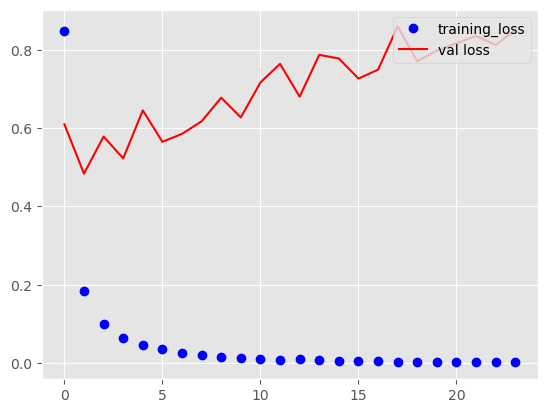

6/6 [==============================] - 0s 51ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2.], dtype=float32)
test pred :  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
  

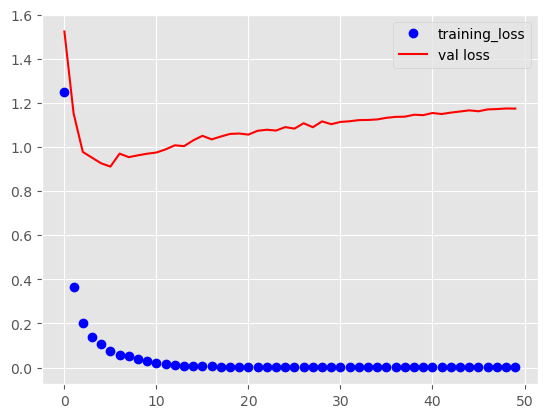

7/7 [==============================] - 0s 50ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2

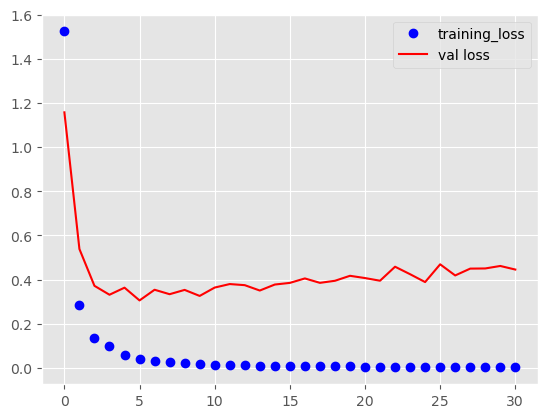

9/9 [==============================] - 1s 51ms/step
pred :  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1

In [9]:
model_choice = 'cnn_1d'
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION, TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list), collections.defaultdict(list)
TEST_BOOTSTRAP = collections.defaultdict(list)
tableau_perf, bootstrap_collect = run_model('Anophele_identif', model_choice)
TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC = tableau_perf
TEST_BOOTSTRAP = bootstrap_collect
df_res_anophele_ident = show_table_results_classif(TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC,
                                                 TEST_BOOTSTRAP, "Anophele Identif 4 classes on CNN",position = 0)

del tableau_perf, bootstrap_collect, TEST_ACCURACY, TEST_BALANCED_ACCURACY, TEST_RECALL, TEST_PRECISION,TEST_F1_SCORE, TEST_ACC_BY_CAT, TEST_CM, TEST_ROC_AUC, TEST_BOOTSTRAP


In [10]:
display(df_res_anophele_ident)#we keep this one 

,PATTES,TETE,THORAX
Metrics,,,
Test accuracy,0.92,0.79,0.87
,"[0.88,0.96]","[0.74,0.85]","[0.84,0.92]"
Test balanced accuracy,0.90,0.81,0.86
,"[0.85,0.95]","[0.76,0.85]","[0.82,0.9]"
Mean F1 score,0.88,0.80,0.86
,"[0.83,0.93]","[0.76,0.85]","[0.82,0.91]"
F1 score by categories,[1. 0.87 1. 0.68],[0.99 0.74 1. 0.51],[0.98 0.84 0.98 0.67]
Mean precision,0.87,0.80,0.88
,"[0.83,0.93]","[0.76,0.85]","[0.84,0.93]"
